In [774]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn 
import plotly
from chart_studio import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
import plotly.io as pio
import calendar
import cufflinks as cf


## CocoCola _Quarters Forecasting

In [775]:
df = pd.read_excel(r"C:\Users\Adith\Desktop\Data Science_Excel R\home assignments\Forecasting and time series\CocaCola_Sales_Rawdata.xlsx")

Data Exploration

In [776]:
df.head()

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996

In [777]:
#checking for any null values 
df.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [778]:
#checking for any duplicated values 
df[df.duplicated()]

Empty DataFrame
Columns: [Quarter, Sales]
Index: []

In [779]:
#unique values for each feature 
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [780]:
#checking with info of our data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


<AxesSubplot:>

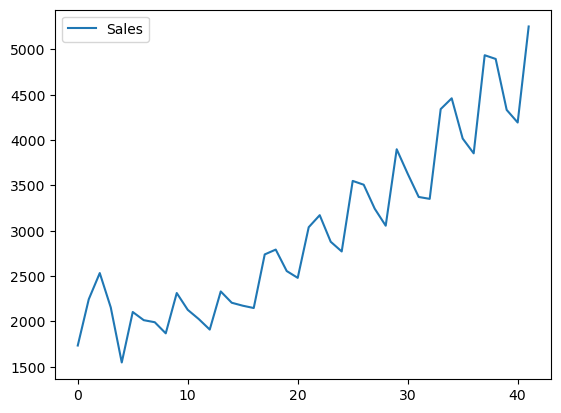

In [781]:
#plotting for inferences of quarters
df.plot()

We observe that we have captured upward trend with sales also as magnitude are not constant we have a multiplicative seasonality, with mean and variance not being constant which tells us our data is non stationary

In [782]:
#checking with descriptive statistics
df.describe()

Sales
count    42.000000
mean   2994.353308
std     977.930896
min    1547.818996
25%    2159.714247
50%    2782.376999
75%    3609.250000
max    5253.000000

## Feature Engineering

In [783]:
#converting quarters to years 
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head()

Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987

In [784]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01
5   Q2_87  2104.411995      Q2 1987 1987-04-01
6   Q3_87  2014.362999      Q3 1987 1987-07-01
7   Q4_87  1991.746998      Q4 1987 1987-10-01
8   Q1_88  1869.049999      Q1 1988 1988-01-01
9   Q2_88  2313.631996      Q2 1988 1988-04-01

In [785]:
#extracting quarters and putting into a column 
df['Quarters'] = 0
for i in range(42):
    n= df['Quarter'][i]
    df['Quarters'][i]= n[0:2]

df.head()

Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1

In [786]:
#creating dummy variables for quarters 
quar_dum = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df,quar_dum),axis=1)

In [787]:
df1.head()

Quarter        Sales Quarter_Year       Date Quarters  Q1  Q2  Q3  Q4
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   1   0   0   0
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   0   1   0   0
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   0   0   1   0
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   0   0   0   1
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   1   0   0   0

In [788]:
#dropping all unnecessary columns 
df1.drop(['Quarters','Quarter_Year'],axis=1,inplace=True)
df1.head()

Quarter        Sales       Date  Q1  Q2  Q3  Q4
0   Q1_86  1734.827000 1986-01-01   1   0   0   0
1   Q2_86  2244.960999 1986-04-01   0   1   0   0
2   Q3_86  2533.804993 1986-07-01   0   0   1   0
3   Q4_86  2154.962997 1986-10-01   0   0   0   1
4   Q1_87  1547.818996 1987-01-01   1   0   0   0

In [789]:
#setting our date feature as index 
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [790]:
df1.head()

Quarter        Sales  Q1  Q2  Q3  Q4
Date                                           
1986-01-01   Q1_86  1734.827000   1   0   0   0
1986-04-01   Q2_86  2244.960999   0   1   0   0
1986-07-01   Q3_86  2533.804993   0   0   1   0
1986-10-01   Q4_86  2154.962997   0   0   0   1
1987-01-01   Q1_87  1547.818996   1   0   0   0

In [791]:
#extracting Month and year  as independent features
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b")
df["year"] = df.Date.dt.strftime("%Y")
df.head()

Quarter        Sales Quarter_Year       Date Quarters month  year
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   Jan  1986
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   Apr  1986
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   Jul  1986
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   Oct  1986
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   Jan  1987

## EDA and Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

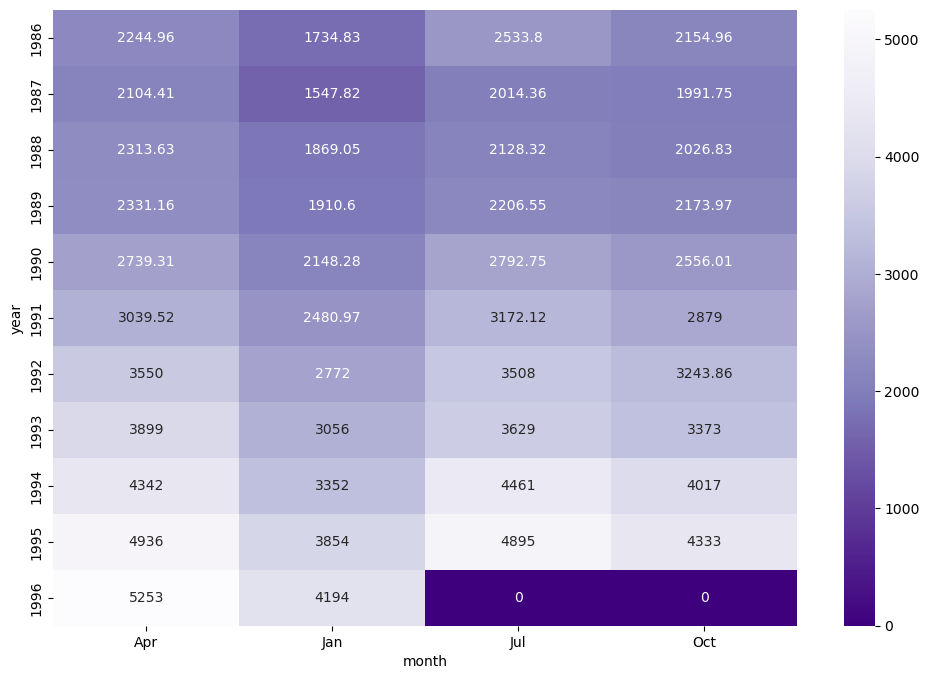

In [792]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc='mean',fill_value=0)
sn.heatmap(heatmap_y_month,annot=True,fmt="g",cmap='Purples_r')

According to heatmap we can observe that the sales from 1996 to 1986 have increased this indicates we have an upward trend with sales but in the year 1996 the month of july and august there were no sales but since we have an upward trend we can say about in fututre cococola will be a bigger brand 

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

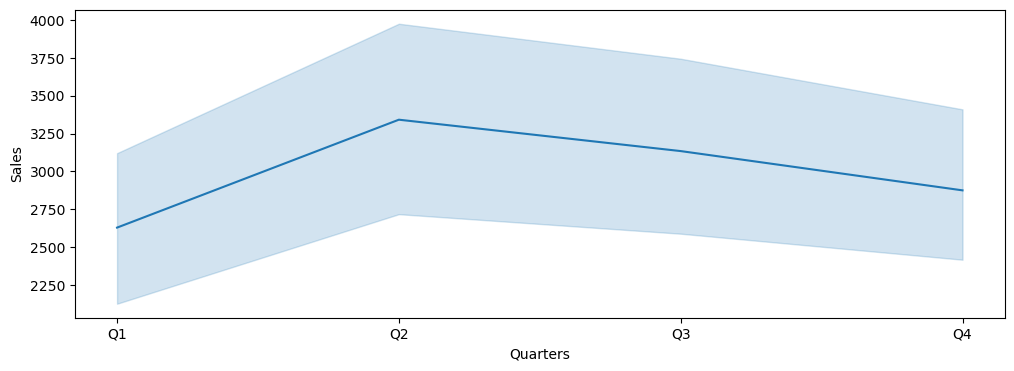

In [793]:
#plotting with quarters and sales 
plt.figure(figsize=(12,4))
sn.lineplot(x='Quarters',y='Sales',data=df)

<AxesSubplot:xlabel='year', ylabel='Sales'>

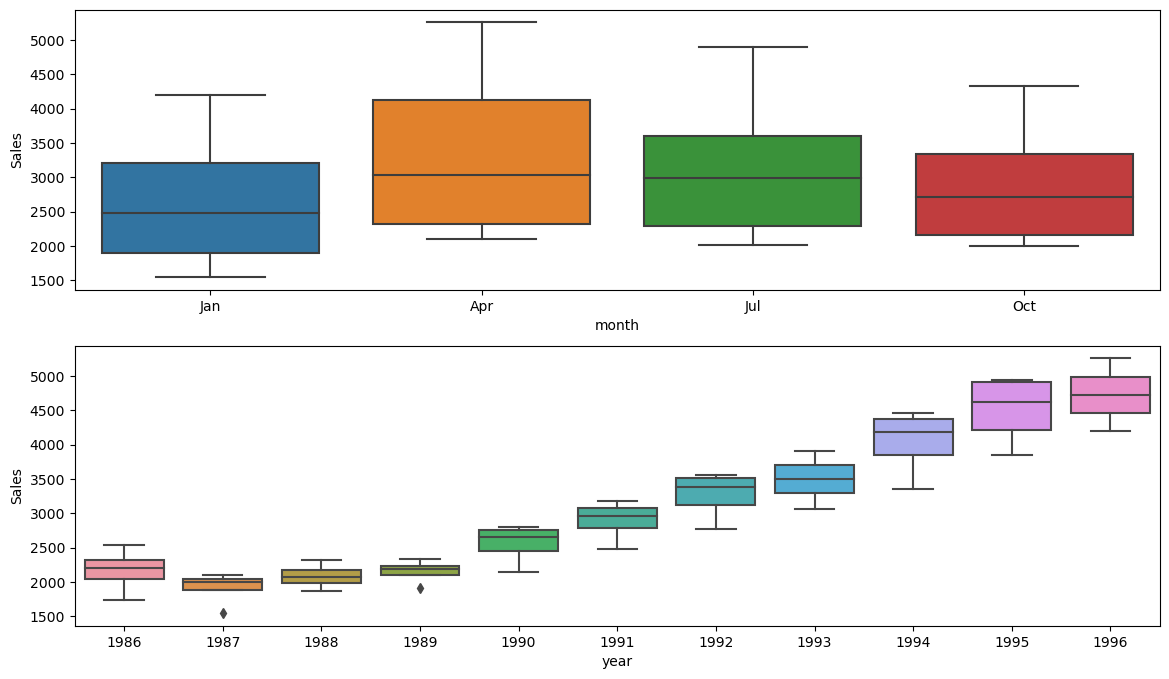

In [794]:
#box plot for checking outliers 
plt.figure(figsize=(14,8))
plt.subplot(211)
sn.boxplot(x='month',y='Sales',data=df)
plt.subplot(212)
sn.boxplot(x ='year',y='Sales',data=df)

<AxesSubplot:ylabel='Density'>

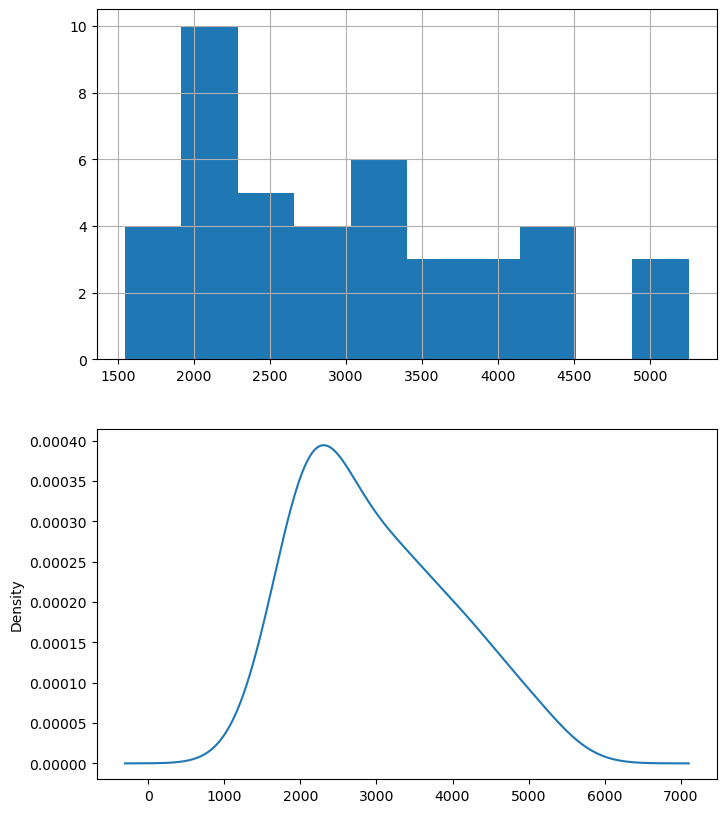

In [795]:
#Sales histplot and density plot 
plt.figure(figsize=(8,10))
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind = 'kde')



Lag Plots

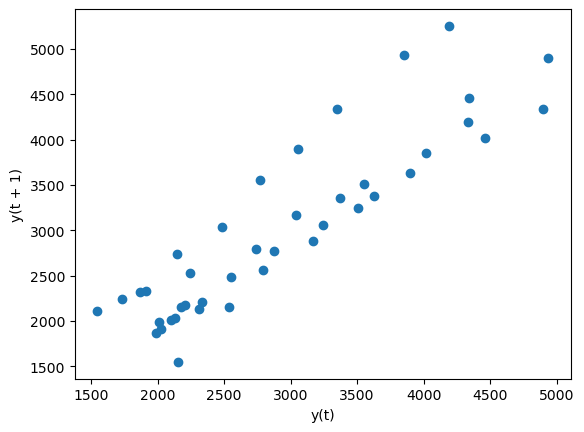

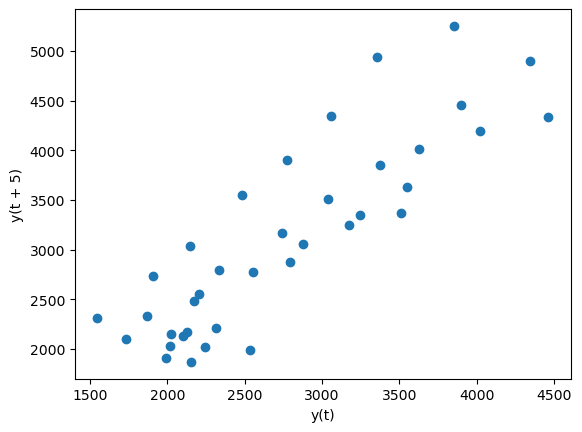

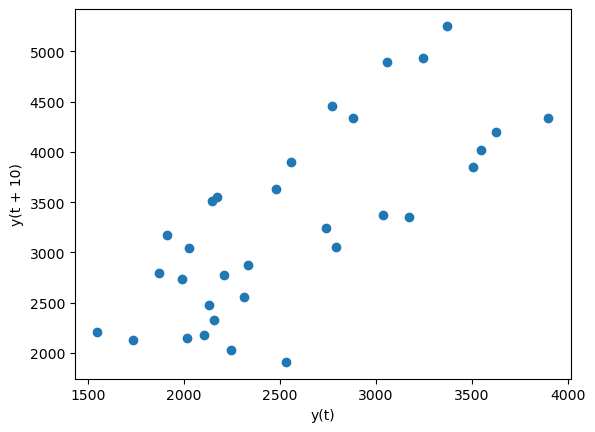

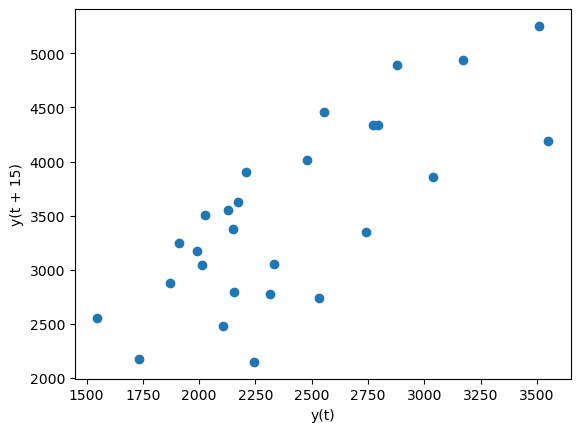

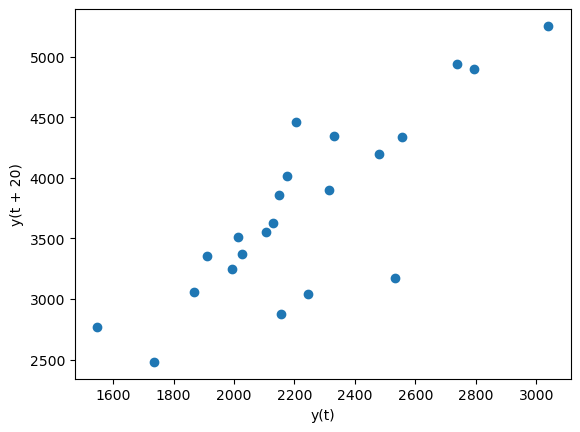

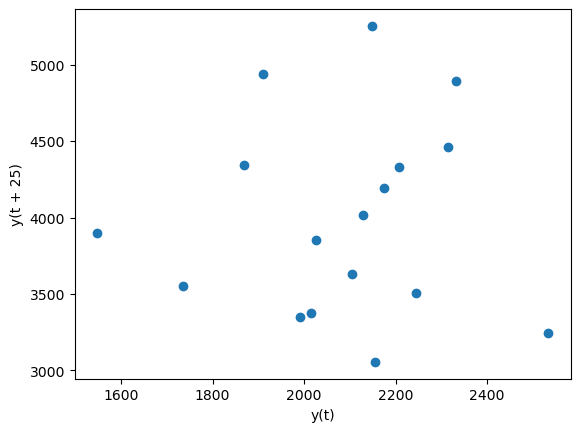

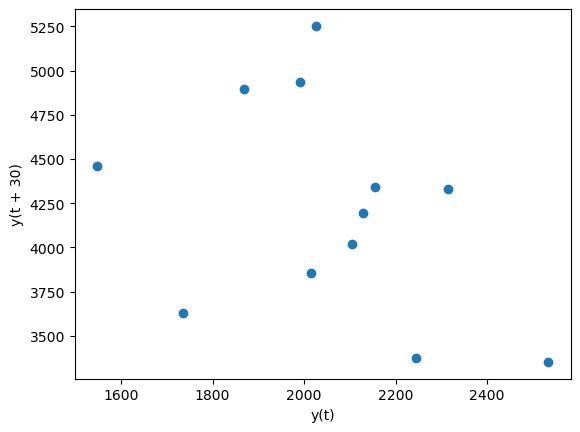

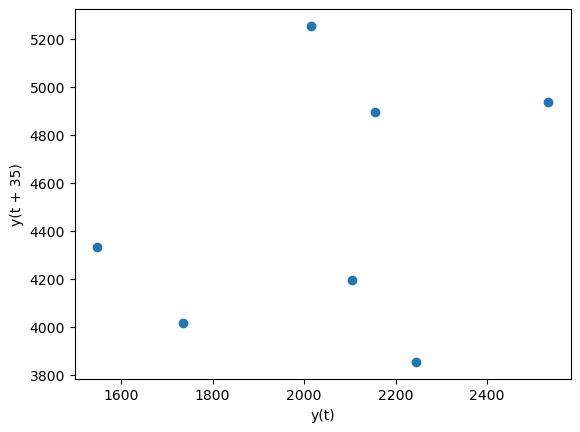

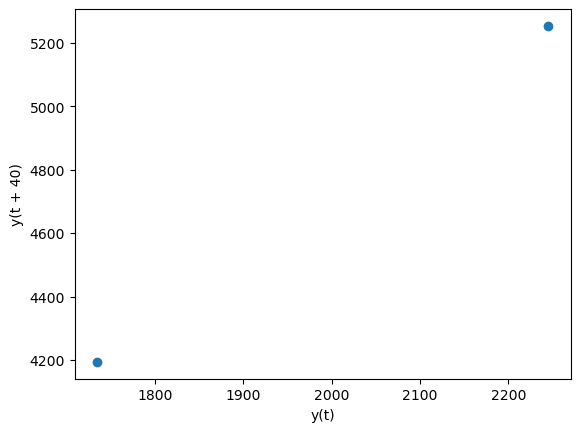

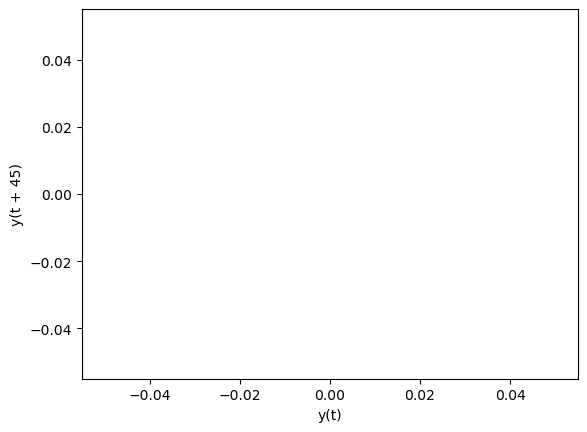

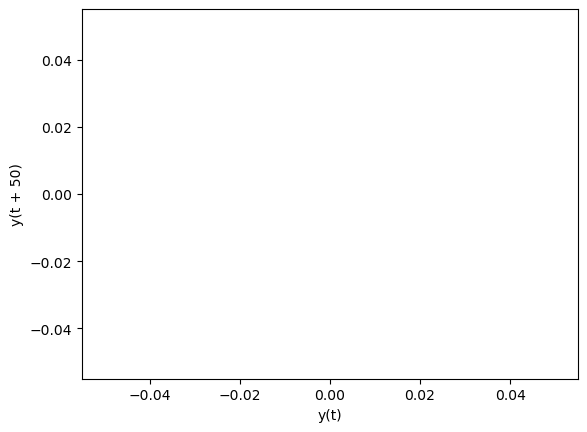

In [796]:
for i in [1,5,10,15,20,25,30,35,40,45,50]:
    pd.plotting.lag_plot(df.Sales,lag = i)
    plt.show()
  

    

Moving Average

In [797]:
#moving average  using plotly
x = pd.date_range('1986-01-01', periods=30, freq='D')
y = df.Sales

window_sizes = [5,10,15,20]
trend_length = 10

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y, name='Original Data')
)

for window_size in window_sizes:
    rolling_mean = y.rolling(window_size).mean()
    fig.add_trace(
        go.Scatter(x=x, y=rolling_mean, name=f'Simple Moving Average ({window_size} days)')
    )

# Update figure layout
fig.update_layout(title='Moving Average Sales', xaxis_title='Date', yaxis_title='Value',height = 350)

# Show figure
fig.show()


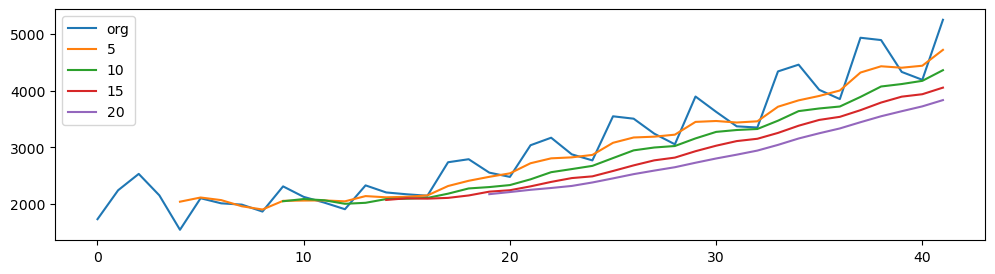

In [798]:
#plotting moving average with trends 
plt.figure(figsize=(12,3))
df.Sales.plot(label="org")
for i in range(5,25,5):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

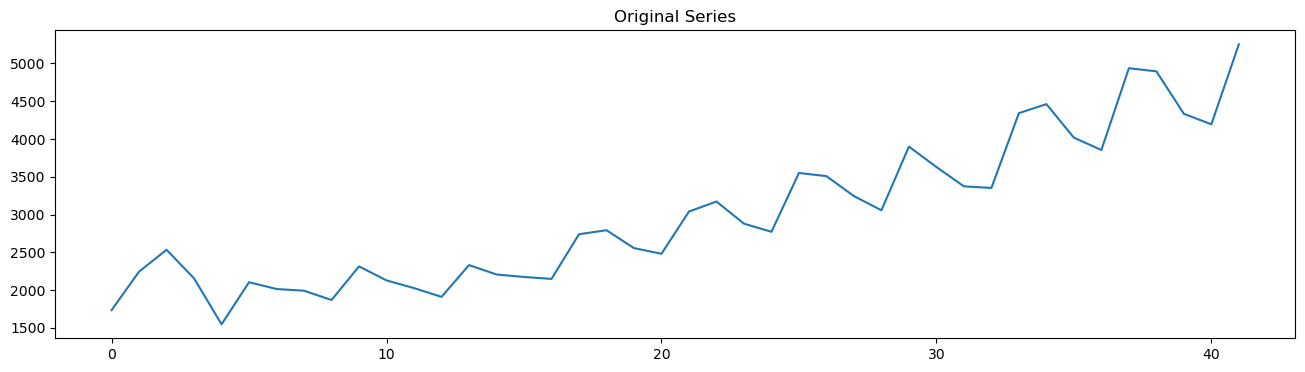

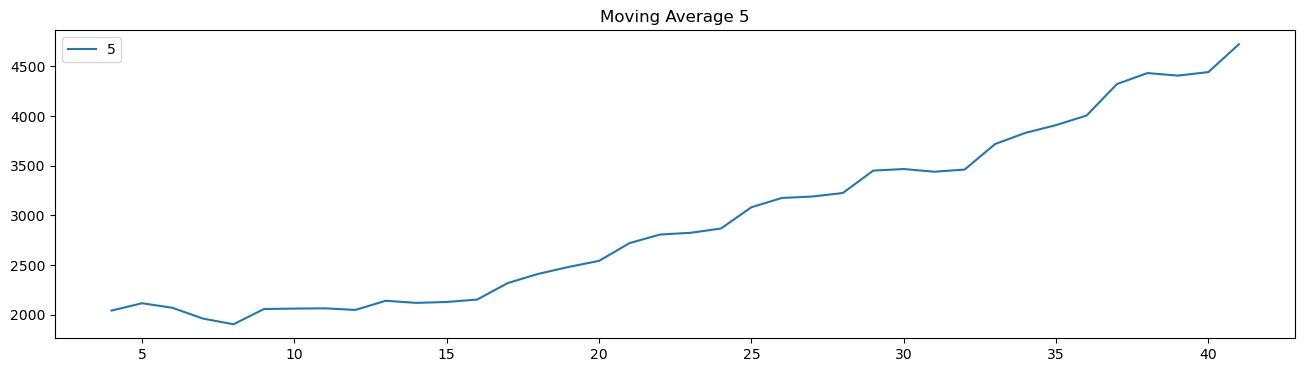

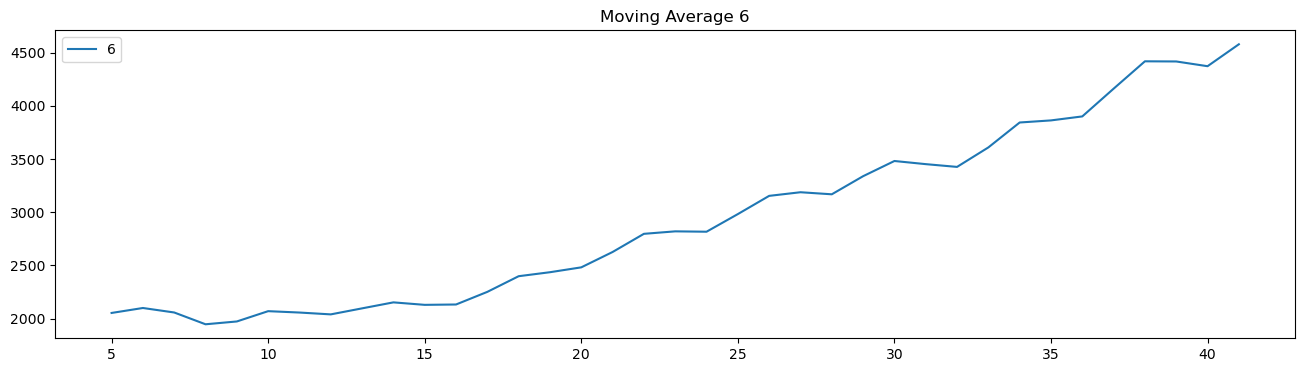

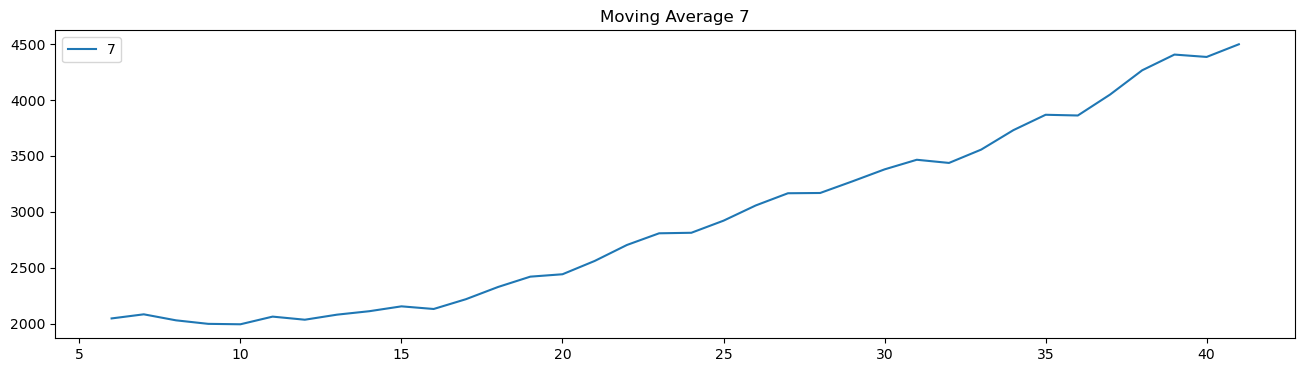

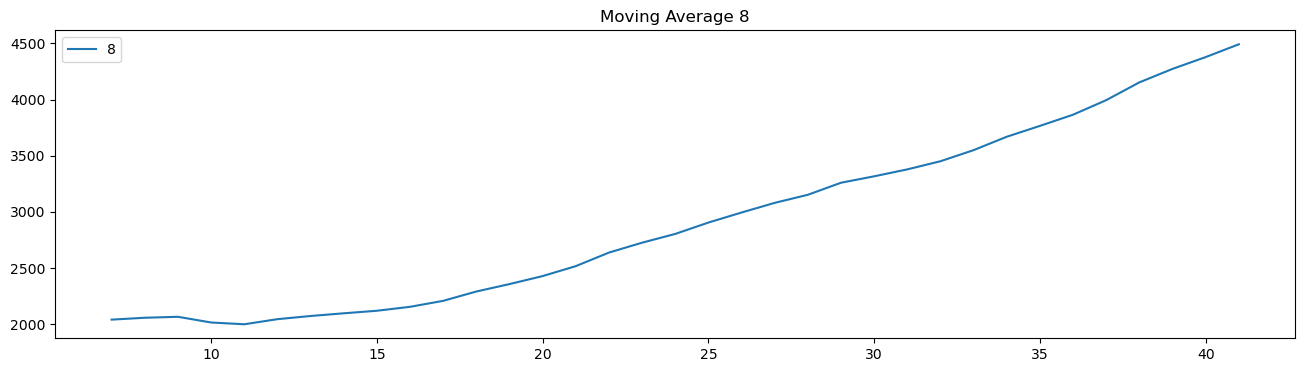

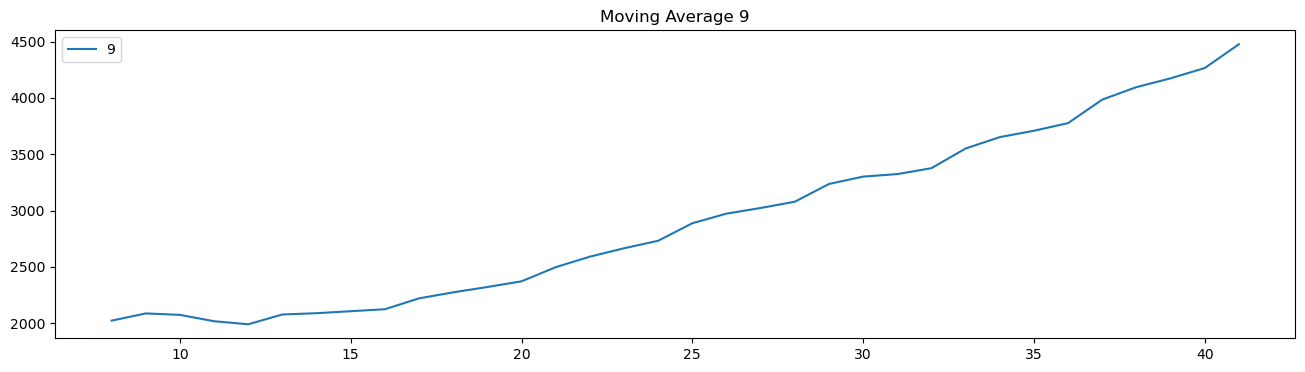

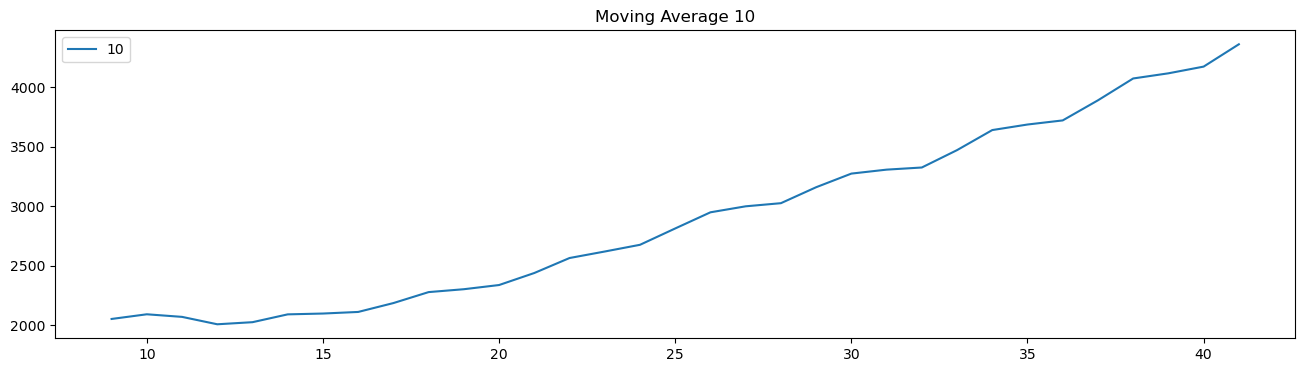

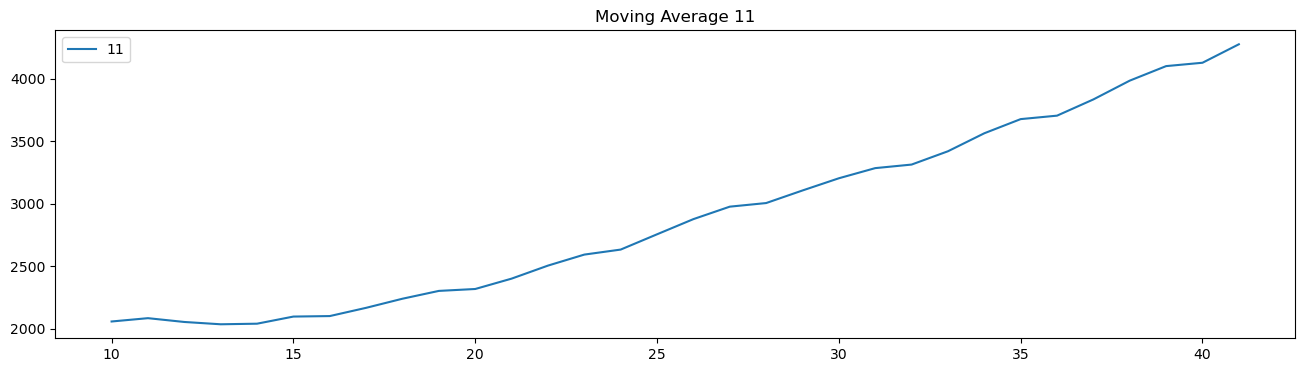

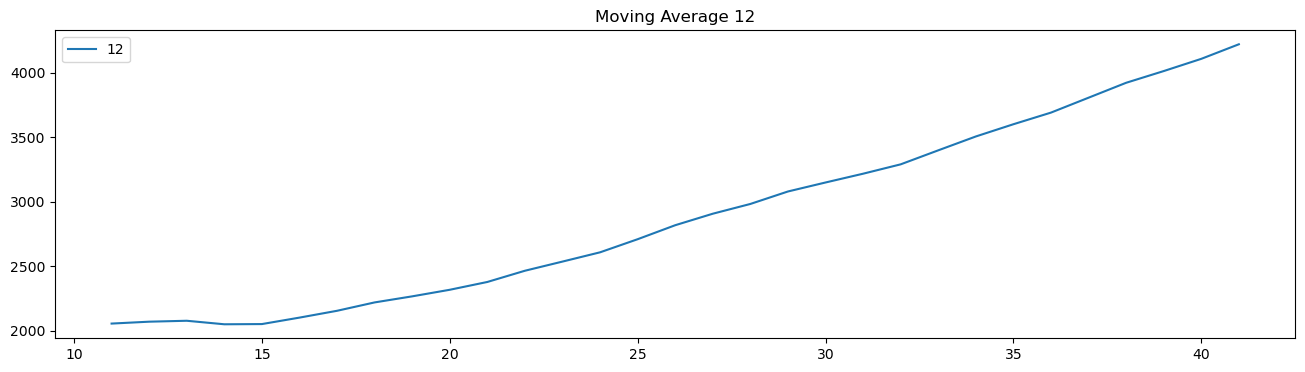

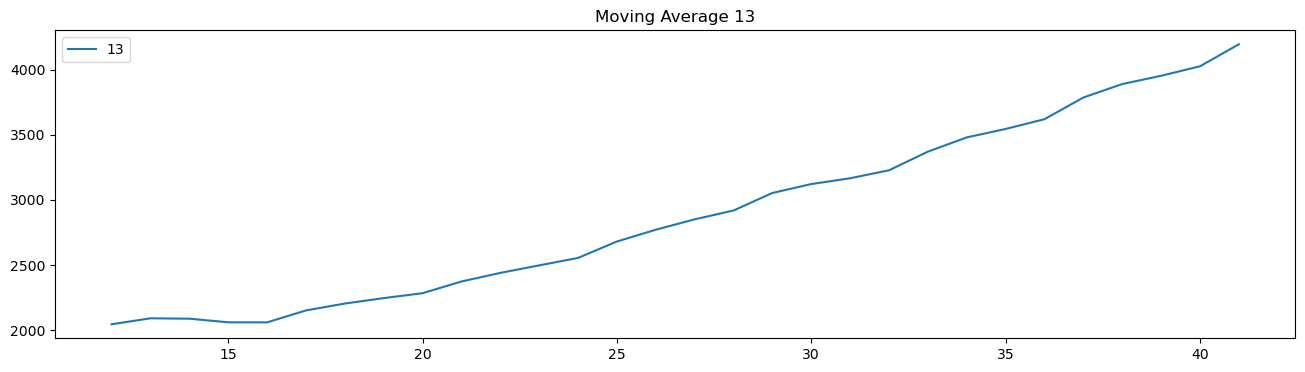

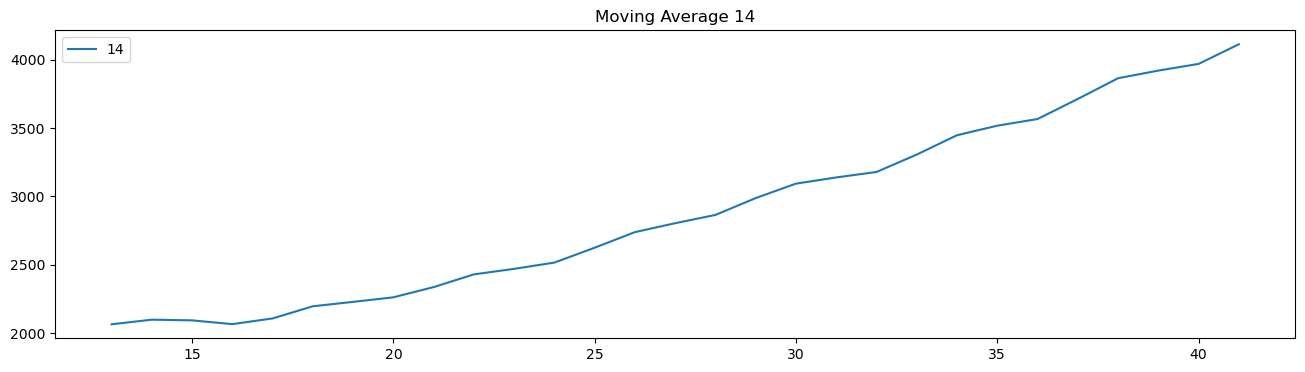

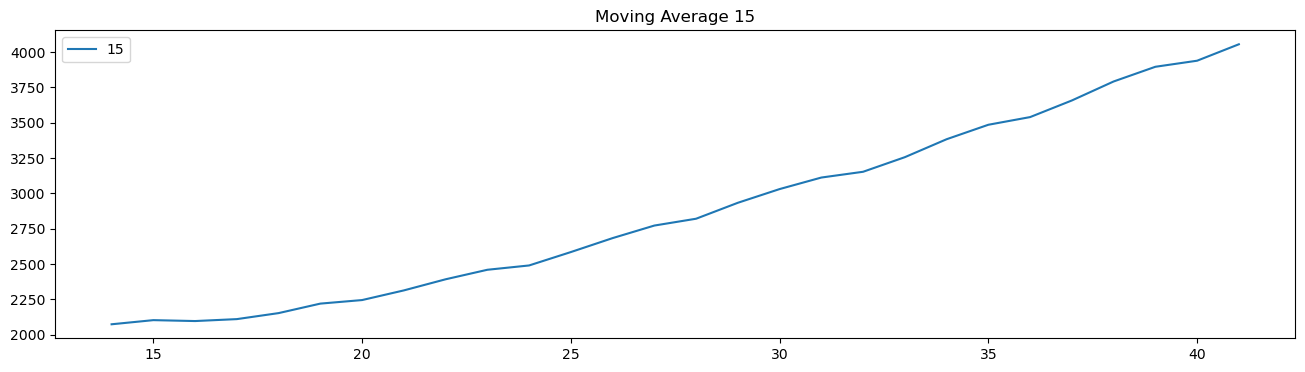

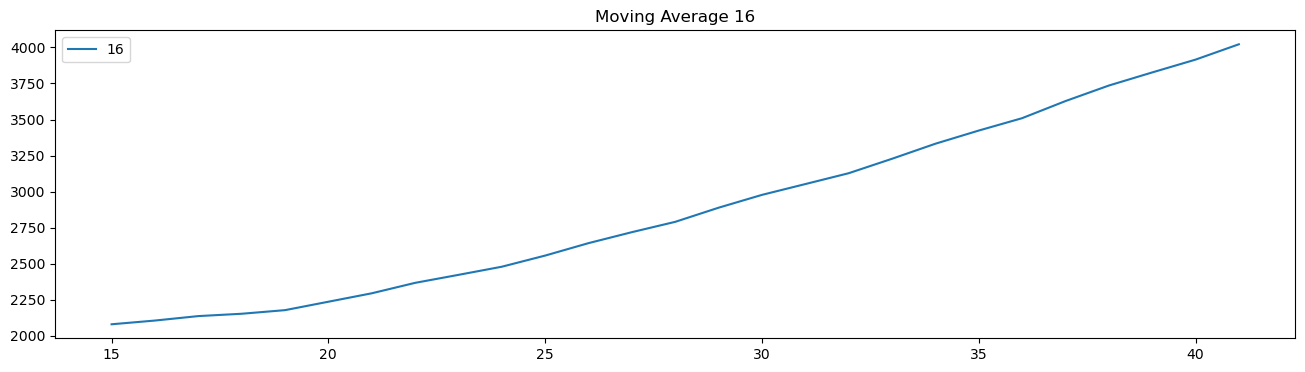

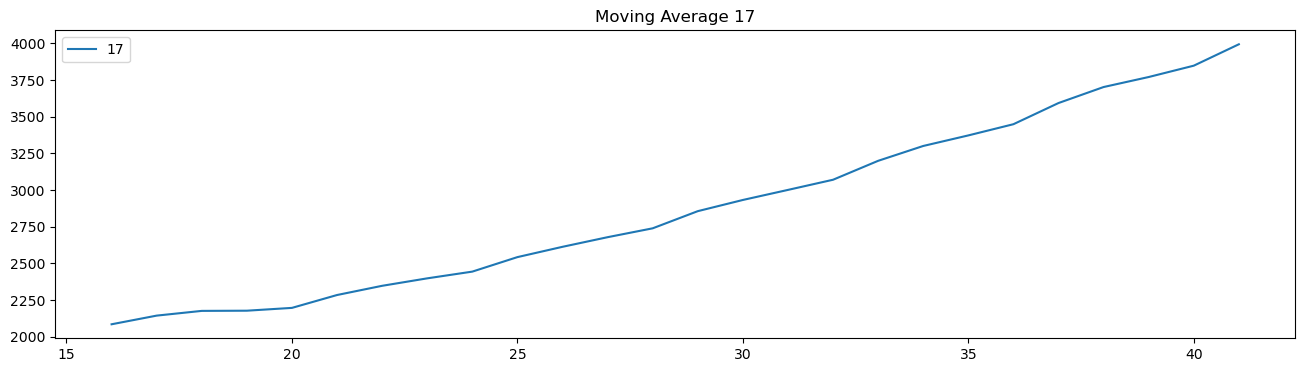

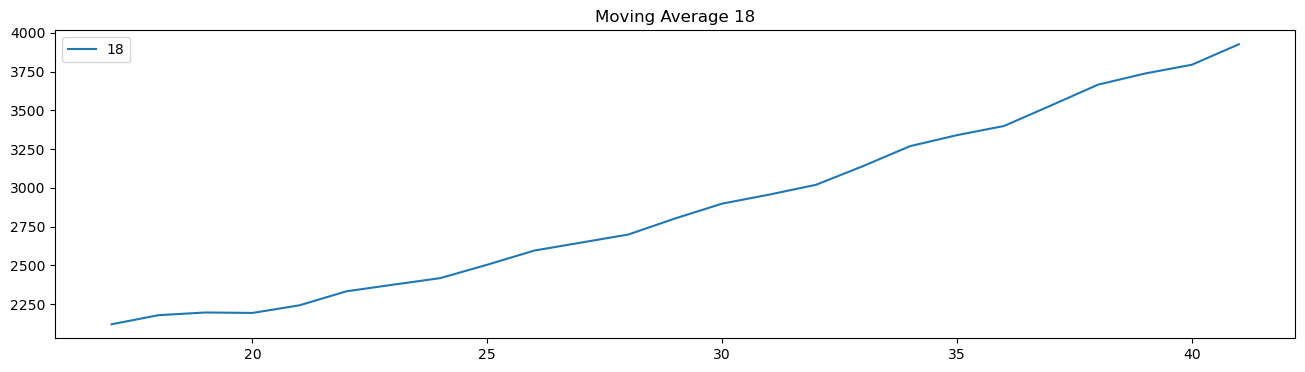

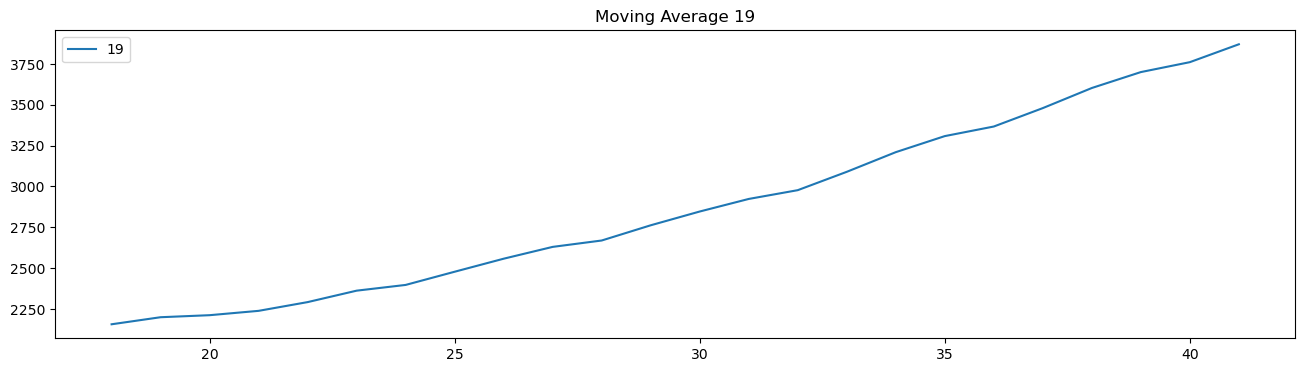

In [799]:
#moving average with independent trends 
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(5,20):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

We observe that the sales have fluctuations after every fifth day, the trend goes upward and again from next day the trend is downward but as we go ahead the trend overall is upward with rise in sales and to future the variations would be same 

In [800]:
#Time series decomposition plot with plotly additive

ts = df.Sales

result = seasonal_decompose(ts, model='additive', period=15)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ts.index, y=ts, name='Original'))

fig.add_trace(go.Scatter(x=result.trend.index, y=result.trend, name='Trend'))

fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'))

fig.add_trace(go.Scatter(x=result.resid.index, y=result.resid, name='Residual'))

fig.update_layout(
    title='Decomposition Plot Additive',
    xaxis_title='Date',
    yaxis_title='Value',
)

fig.show()


In [801]:
#Time series decomposition plot with plotly Multiplicative

ts = df.Sales

result = seasonal_decompose(ts, model='multiplicative', period=15)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ts.index, y=ts, name='Original'))

fig.add_trace(go.Scatter(x=result.trend.index, y=result.trend, name='Trend'))

fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'))

fig.add_trace(go.Scatter(x=result.resid.index, y=result.resid, name='Residual'))

fig.update_layout(
    title='Decomposition Plot Multiplicative',
    xaxis_title='Date',
    yaxis_title='Value',
)

fig.show()


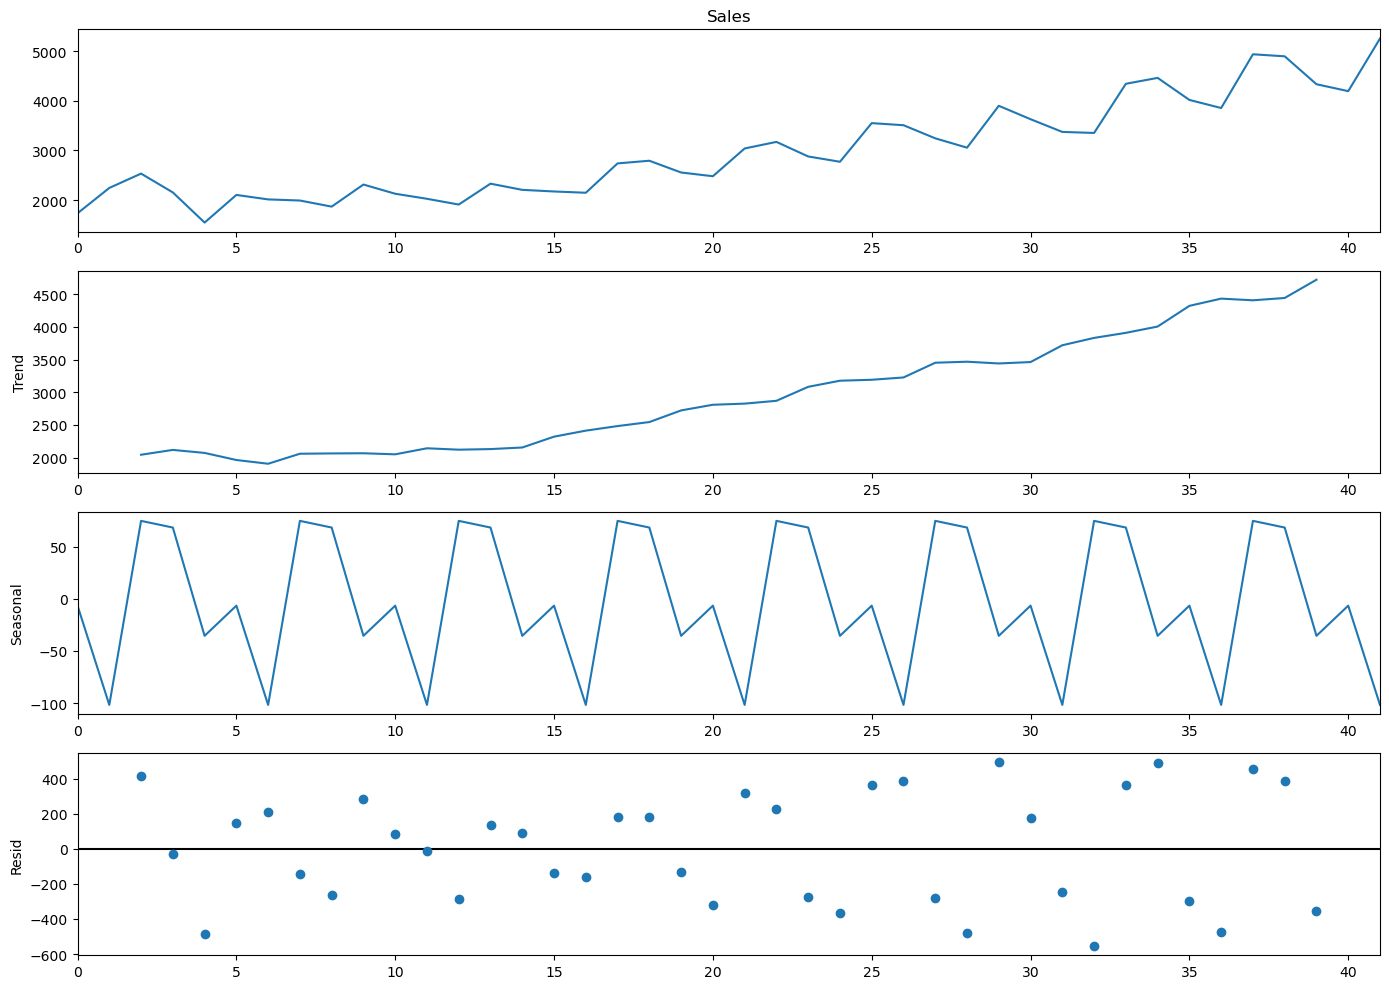

In [802]:
#decomposition times series plot 
decompose_ts_add = seasonal_decompose(df.Sales,period=5)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

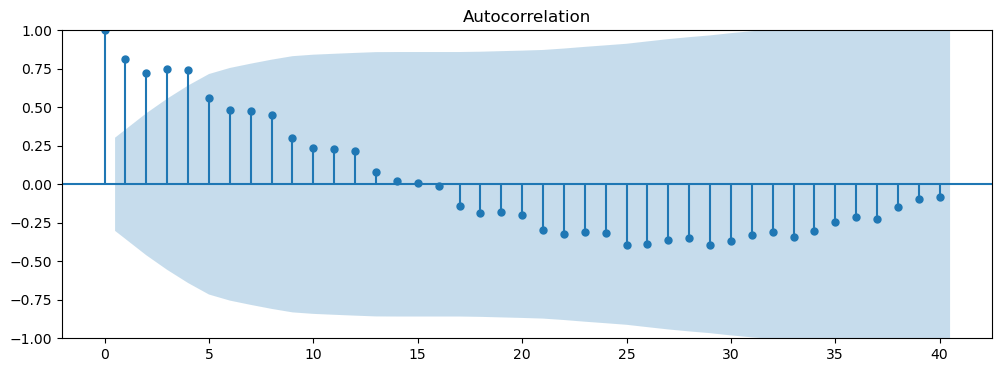

In [803]:
##ACF Plot 
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=40)
    plt.show()


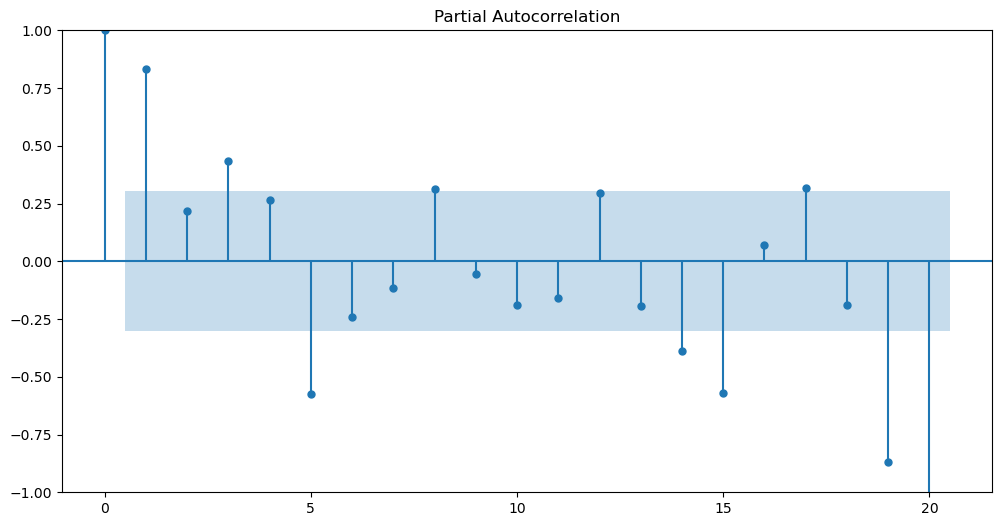

In [804]:
# PACF Plot    
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

## Sampling

Linear Interpolation

In [805]:
#upsampling with respect to month 
upsamp_month = df1.drop(['Quarter','Q1','Q2','Q3','Q4'],axis=1)
upsamp_month = upsamp_month.resample('M').mean()
print(upsamp_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


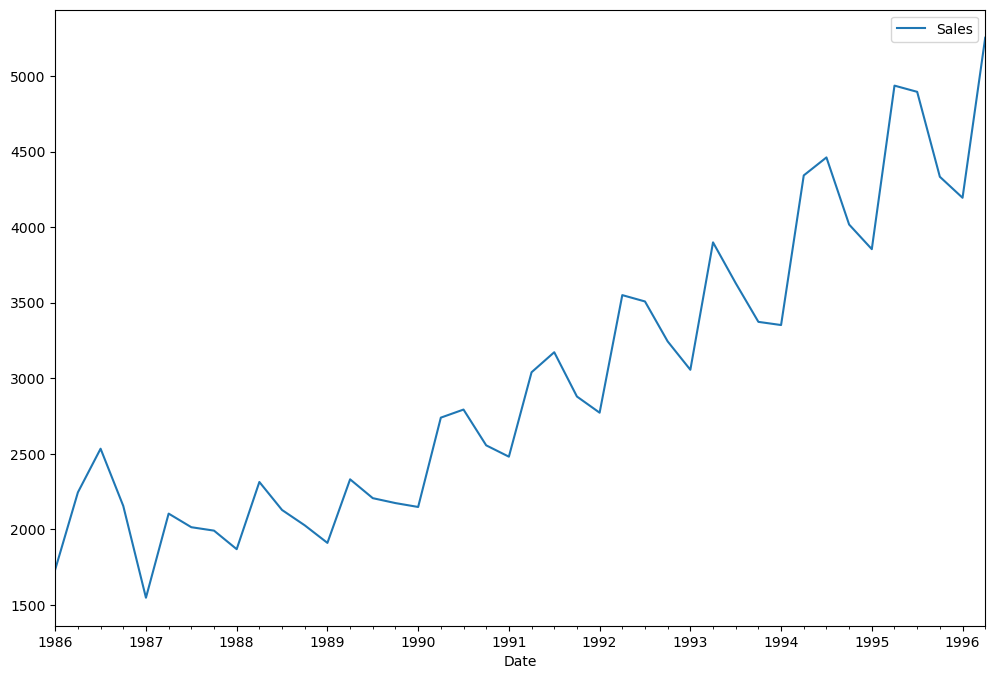

In [806]:
 ## interplation was done for nan values which we get after doing upsampling by month
inter_month = upsamp_month.interpolate(method='linear')
print(inter_month.head(15))
inter_month.plot(figsize=(12,8))
plt.show()

In [807]:
inter_month

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

[124 rows x 1 columns]

In [808]:
 df2 = inter_month.copy()
df2.reset_index(inplace=True)
df2['date'] = pd.to_datetime(df2['Date'])
df2['year'] = df2['Date'].dt.year
df2['month'] = df2['Date'].dt.month
df2['week'] = df2['Date'].dt.isocalendar().week
df2['quarter'] = df2['Date'].dt.quarter
df2['day_of_week'] = df2['Date'].dt.day_name()
df2.drop('Date', axis =1 , inplace= True)
df2[:2]

Sales       date  year  month  week  quarter day_of_week
0  1734.827000 1986-01-31  1986      1     5        1      Friday
1  1904.871666 1986-02-28  1986      2     9        1      Friday

In [809]:
df_1986 = df2[df2['year']==1986][['month','Sales']]
df_1986 = df_1986.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1986'})
df_1987 = df2[df2['year']==1987][['month','Sales']]
df_1987 = df_1987.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1987'})
df_1988 = df2[df2['year']==1988][['month','Sales']]
df_1988 = df_1988.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1988'})
df_1989 = df2[df2['year']==1989][['month','Sales']]
df_1989 = df_1989.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1989'})
df_1990 = df2[df2['year']==1990][['month','Sales']]
df_1990 = df_1990.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1990'})
df_1991 = df2[df2['year']==1991][['month','Sales']]
df_1991 = df_1991.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1991'})
df_1992 = df2[df2['year']==1992][['month','Sales']]
df_1992 = df_1992.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1992'})
df_1993 = df2[df2['year']==1993][['month','Sales']]
df_1993 = df_1993.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1993'})
df_1994 = df2[df2['year']==1994][['month','Sales']]
df_1994 = df_1994.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1994'})
df_1995 = df2[df2['year']==1995][['month','Sales']]
df_1995 = df_1995.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1995'})

df_year = df_1986.merge(df_1987,on='month').merge(df_1988,on='month').merge(df_1989,on='month').merge(df_1990,on='month')\
.merge(df_1991,on='month').merge(df_1992,on='month').merge(df_1993,on='month').merge(df_1994,on='month').merge(df_1995,on='month')

# top levels
top_labels = ['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)'
          ,'rgb(197, 237, 221)','rgb(236, 249, 244)']

# X axis value 
df_year = df_year[['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1986['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1986['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

        
fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template= 'plotly_white',
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(248, 248, 255)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()


According to th plot above we observe that the rise in trend of for cococola gradually rises from peak of march to july and then dips down from august to january ,we also notice  that sales are increasing from 1986 to 1995,to be noted that we dont have enough data for 1996

In [810]:
#Average sales analysis

df_m_sa = df2.groupby('month').agg({"Sales" : "mean"}).reset_index()
df_m_sa['Sales'] = round(df_m_sa['Sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Sales'].astype(str) 

df_w_sa = df2.groupby('week').agg({"Sales" : "mean"}).reset_index() 
df_q_sa = df2.groupby('quarter').agg({"Sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#03A64A'
df_m_sa['color'][:-1] = '#025940'
df_w_sa['color'] = '#04BF8A'
# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"),)

fig.add_trace(go.Bar(x=df_m_sa['Sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#8C1F28','#044040','#591C21','#D92525','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Sales'], mode='lines+markers', fill='tozeroy', fillcolor='#A0CD60',
                     marker=dict(color= '#002333'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()



In [811]:
# data
df_dw_sa = df2.groupby('day_of_week').agg({"Sales" : "mean"}).reset_index()
df_dw_sa.Sales = round(df_dw_sa.Sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#012030'], text='Sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8C1F28', family="Lato, sans-serif"),
                  font=dict(color='#8C1F28'),
                  hoverlabel=dict(bgcolor="#FFCB9A", font_size=13, font_family="Lato, sans-serif"))


According to our weekly analysis we can say tha highest sales ar emade on tuesday. we observe that seasonal changes are observed , with bit more exploration we can find out 

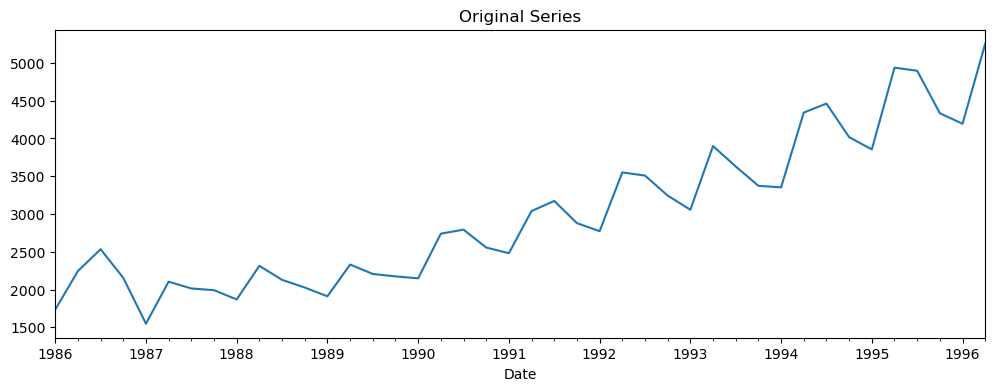

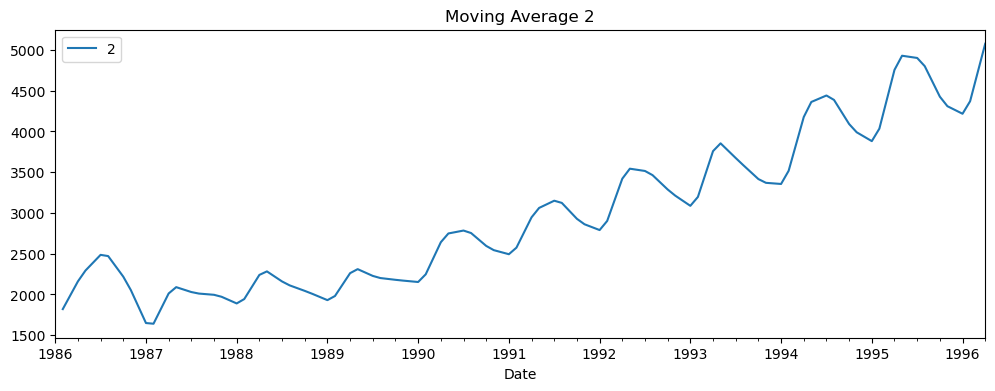

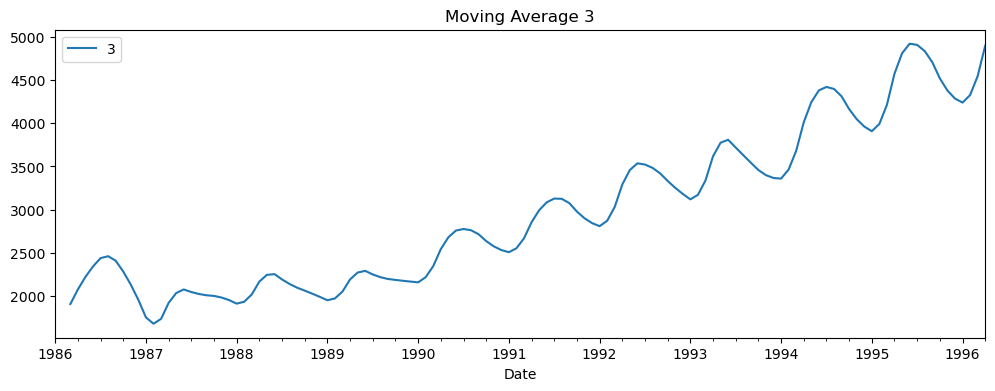

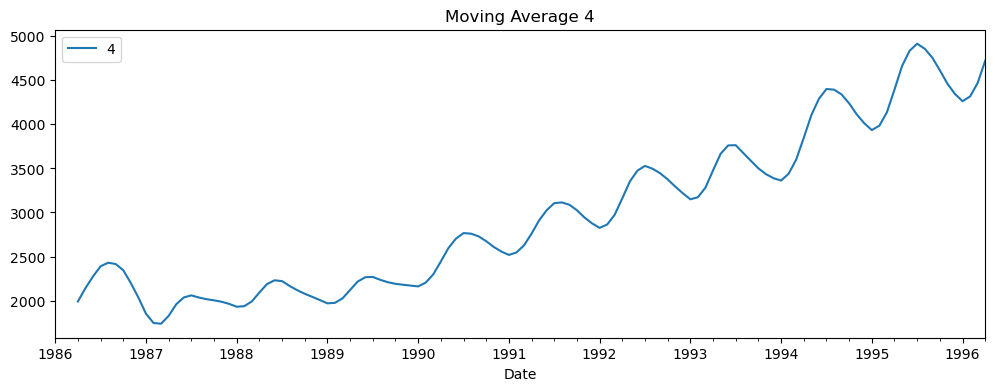

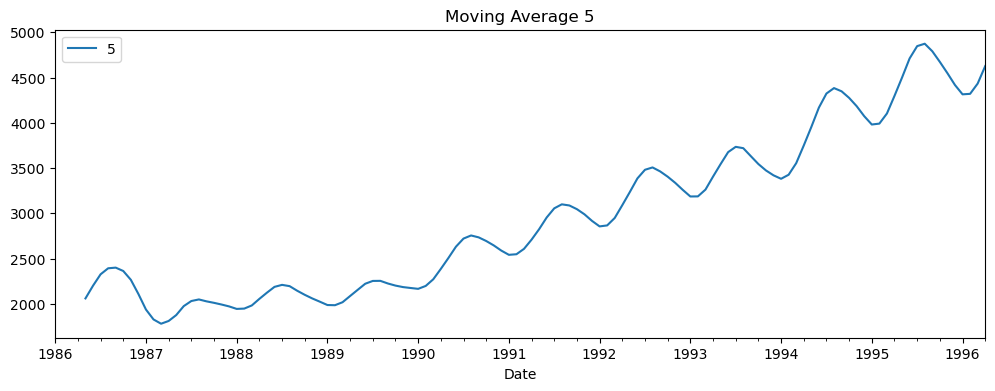

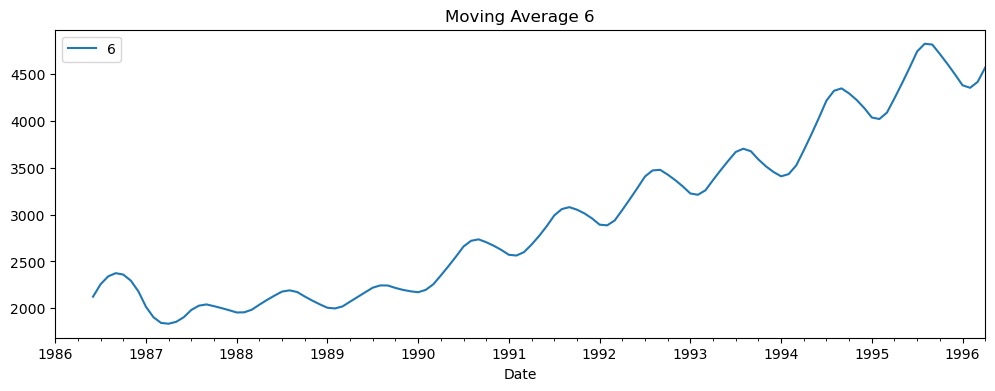

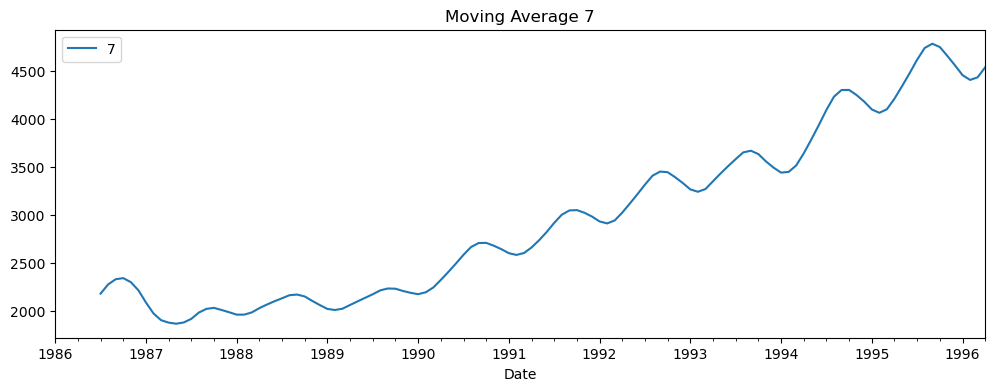

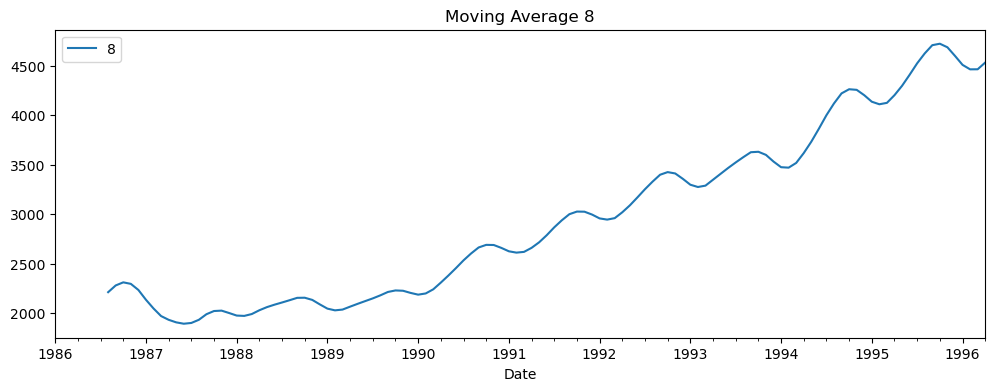

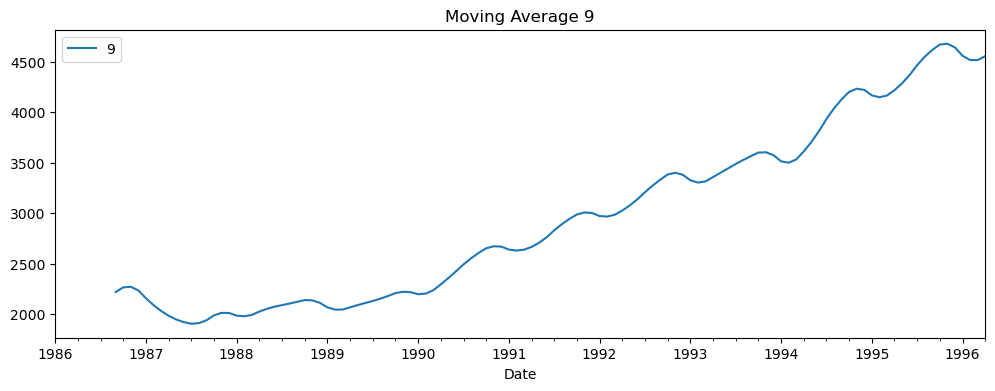

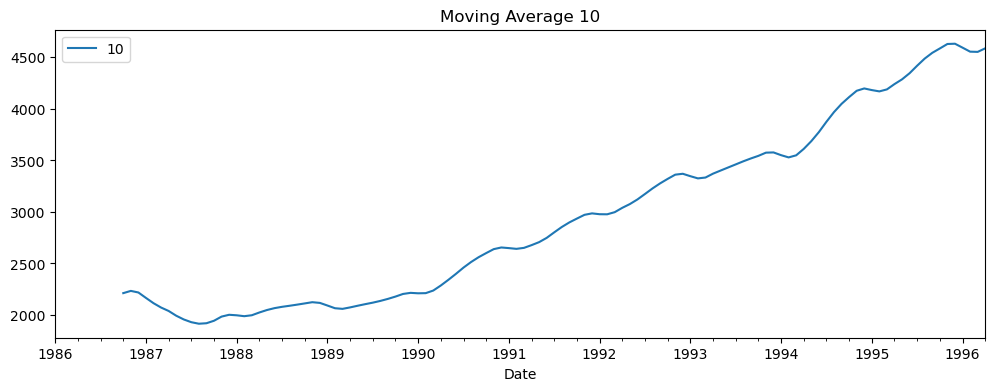

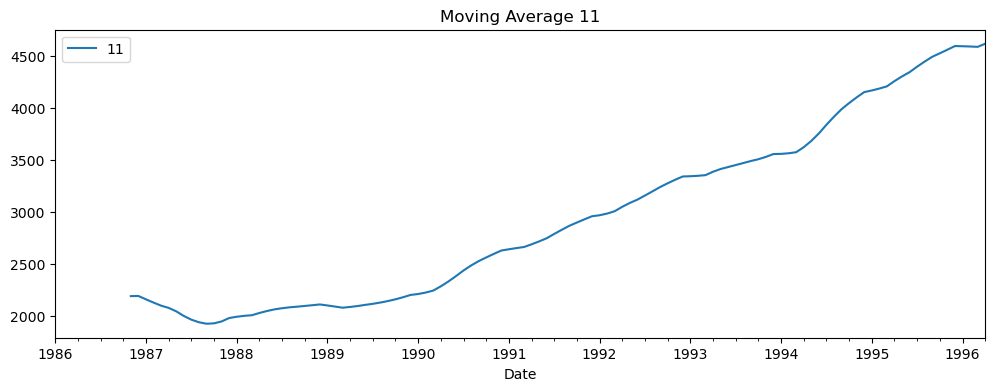

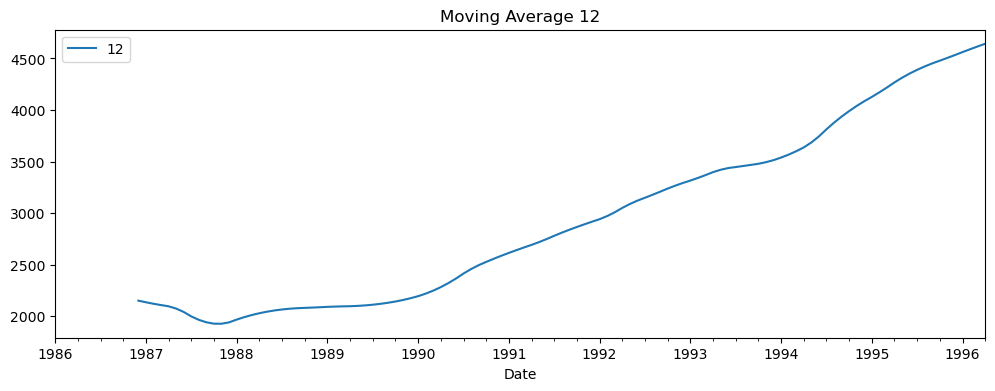

In [812]:
## we know that we dont have enough data for 19996
plt.figure(figsize=(12,4))
inter_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    inter_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()


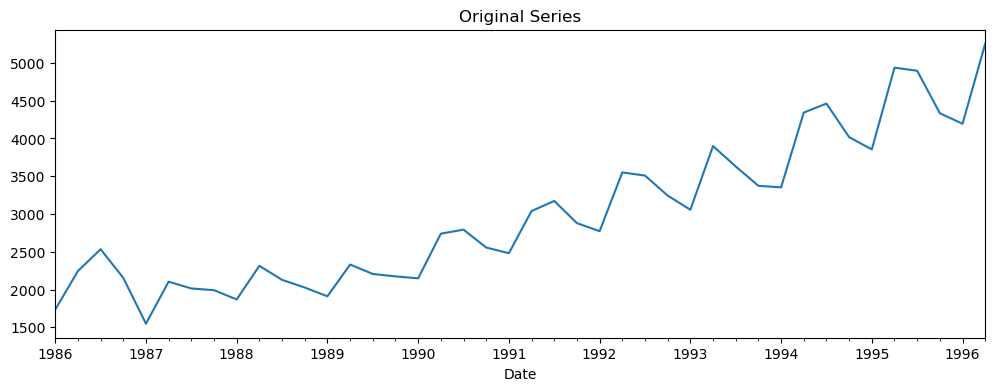

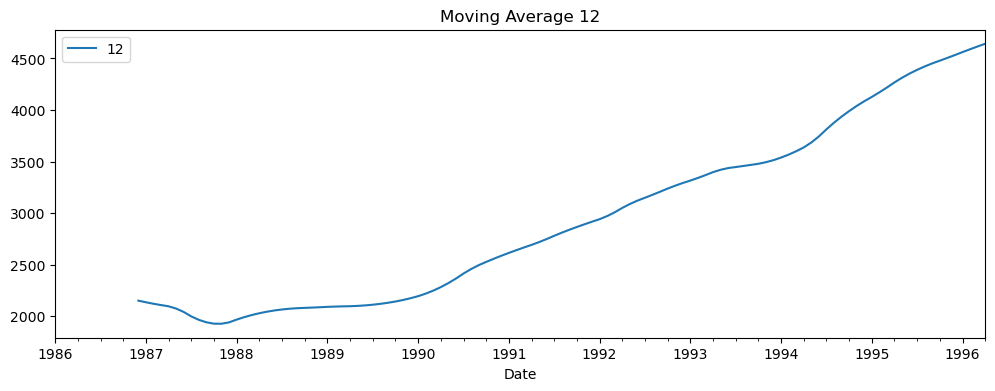

In [813]:
plt.figure(figsize=(12,4))
inter_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
inter_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()


In [814]:
#splitting into train and test data with 2 years of timeseries data
train_data = inter_month[:100]
test_data = inter_month[100:]

In [815]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


In [816]:
## forecasting for last two years ##

In [817]:
train_data.head()

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330

In [818]:
test_data.head()

Sales
Date                   
1994-05-31  4381.666667
1994-06-30  4421.333333
1994-07-31  4461.000000
1994-08-31  4313.000000
1994-09-30  4165.000000

In [819]:
#defining mean absolute percentaage error
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Data driven Model Methods 

Simple Exponential Method

In [820]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.620373886579515 
 Train Root Mean Squared Error = 129.78414718502933 
 Test Root Mean Squared Error = 382.4477417207024


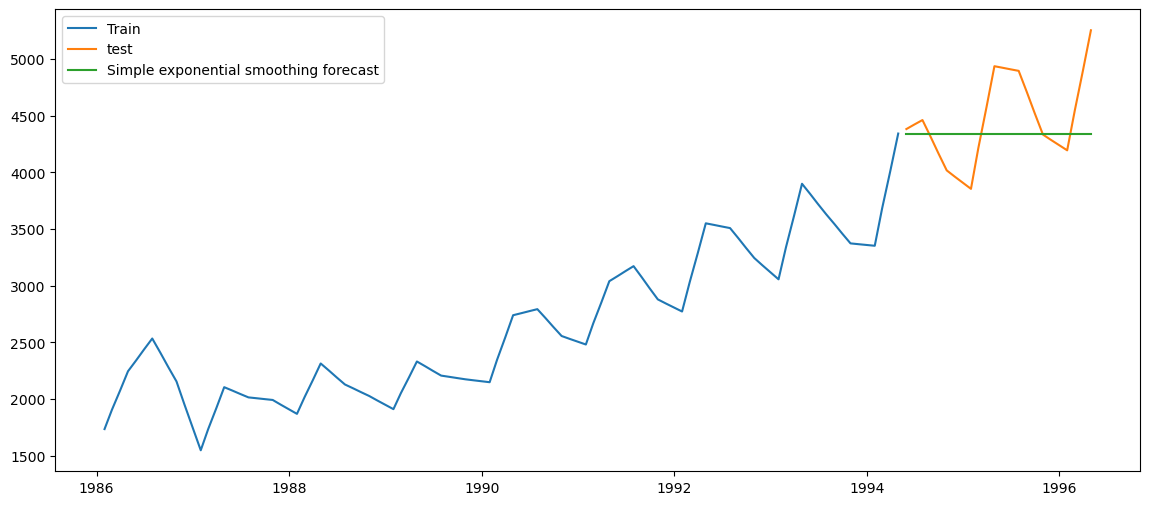

In [821]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()

We observe no captures of seasonality and most recent observations gets higher value compared to older records 

Holt Method (Double Exponential)

In [822]:
#fitting our values for holt method 
hm_mod = Holt(train_data).fit(optimized=True)
test_pred_hm = hm_mod.forecast(24)
train_pred_hm = hm_mod.fittedvalues
test_rmse_hm = sqrt(mean_squared_error(test_pred_hm,test_data.Sales))
train_rmse_hm = sqrt(mean_squared_error(train_pred_hm,train_data))
mape_hm = MAPE(test_pred_hm,test_data.Sales)
mape_hm = MAPE(test_pred_hm,test_data.Sales)
print('Double Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hm),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hm),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hm))



Double Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.49462512277044 
 Train Root Mean Squared Error = 106.04918278537214 
 Test Root Mean Squared Error = 4549.90795083935


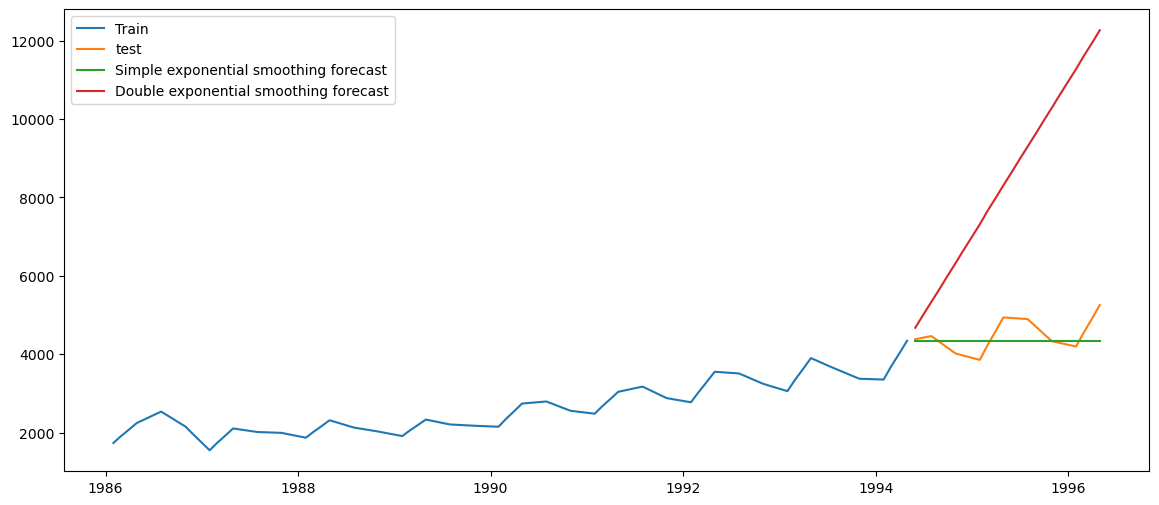

In [823]:
#plotting for holts method
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.legend(loc='best')
plt.show()


We observe that trend was able to capture but level has an absurd magnitude which is affecting our model,also we have failed to capture seasonality

Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

In [824]:
hw_mod = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hw = hw_mod.forecast(24)
train_pred_hw = hw_mod.fittedvalues
test_rmse_hw = sqrt(mean_squared_error(test_pred_hw,test_data.Sales))
train_rmse_hw =sqrt(mean_squared_error(train_pred_hw,train_data))
mape_hw = MAPE(test_pred_hw,test_data.Sales)
print('Additive seasonality and trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw))




Additive seasonality and trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 37.82406870055411 
 Train Root Mean Squared Error = 45.97599540803602 
 Test Root Mean Squared Error = 1938.6377946243854


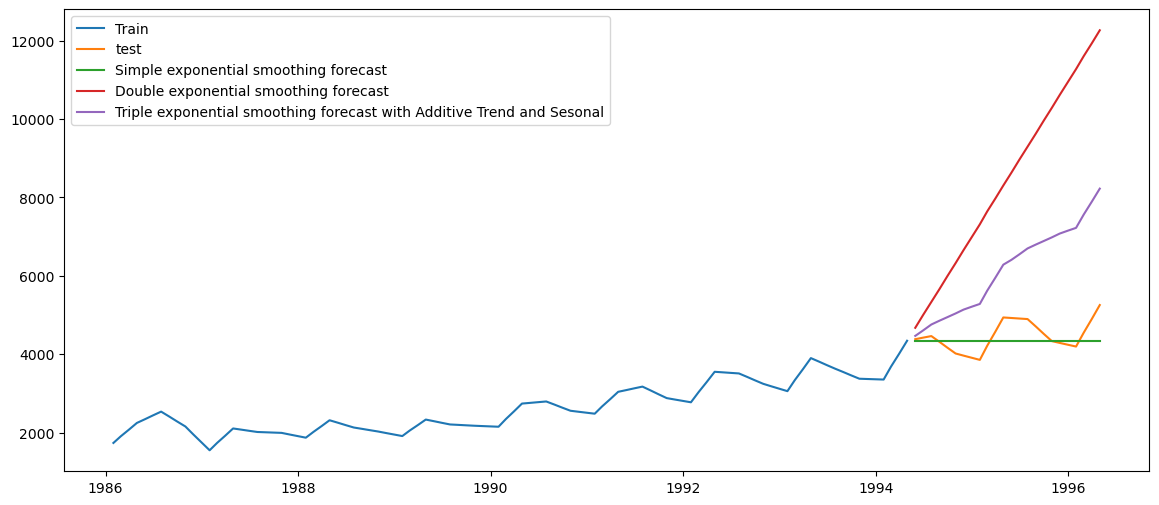

In [825]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

We have captured trend,we also foresee that values that were forecast are higher than the test values,but we have succesfully have captured seasonality

Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [826]:
hw_mod_mul = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hw_mul = hw_mod_mul.forecast(24)
train_pred_hw_mul = hw_mod_mul.fittedvalues
test_rmse_hw_mul = sqrt(mean_squared_error(test_pred_hw_mul,test_data.Sales))
train_rmse_hw_mul =sqrt(mean_squared_error(train_pred_hw_mul,train_data))
mape_hw_mul = MAPE(test_pred_hw_mul,test_data.Sales)
print('multiplicative seasonality and additive trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw_mul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw_mul),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw_mul))




multiplicative seasonality and additive trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 3.6365422435254833 
 Train Root Mean Squared Error = 40.85891607687442 
 Test Root Mean Squared Error = 210.00140597756265


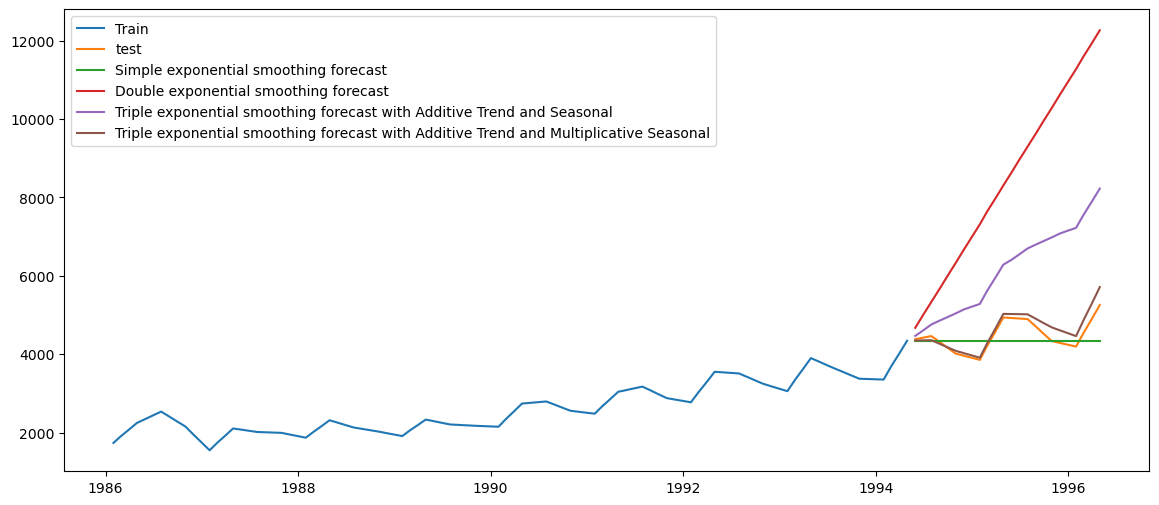

In [827]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Seasonal')
plt.plot(test_pred_hw_mul, label='Triple exponential smoothing forecast with Additive Trend and Multiplicative Seasonal')
plt.legend(loc='best')
plt.show()

We have successfully captured level trend and seasonality, also the errors have come to minimal 

Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [828]:
hw_mod_mul_mul = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hw_mul_mul = hw_mod_mul_mul.forecast(24)
train_pred_hw_mul_mul = hw_mod_mul_mul.fittedvalues
test_rmse_hw_mul_mul = sqrt(mean_squared_error(test_pred_hw_mul_mul,test_data.Sales))
train_rmse_hw_mul_mul =sqrt(mean_squared_error(train_pred_hw_mul_mul,train_data))
mape_hw_mul_mul = MAPE(test_pred_hw_mul_mul,test_data.Sales)
print('Multiplicative seasonality and trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw_mul_mul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw_mul_mul),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw_mul_mul))




Multiplicative seasonality and trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.308444220296386 
 Train Root Mean Squared Error = 40.06681930340377 
 Test Root Mean Squared Error = 366.46433545020244


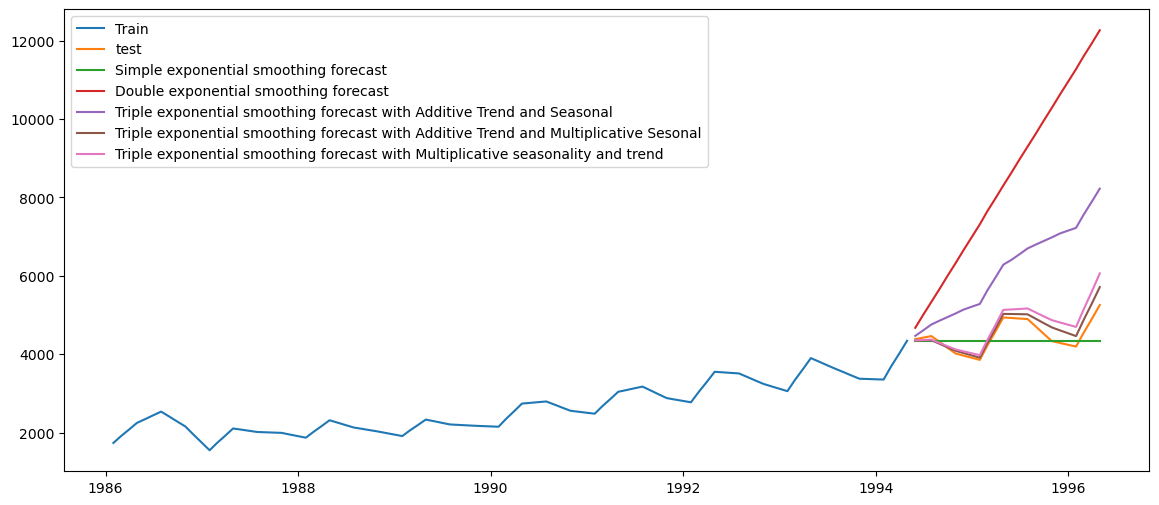

In [829]:
#plotting for both multiplicative trend and seasonality
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Seasonal')
plt.plot(test_pred_hw_mul, label='Triple exponential smoothing forecast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_hw_mul_mul,label ="Triple exponential smoothing forecast with Multiplicative seasonality and trend")
plt.legend(loc='best')
plt.show()

We can easily figure out the trend and seasonality, the trend for sales is not linear and we observe lot of variations with the graph

In [830]:

Results = {"Models":pd.Series(["Simple_Exp","holt method","holt winter","holt_mul_ad","holt_mul_mul"\
                                  ]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_hm,train_rmse_hw,train_rmse_hw_mul,train_rmse_hw_mul_mul]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_hm,mape_hw,mape_hw_mul,mape_hw_mul_mul]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_hm,test_rmse_hw,test_rmse_hw_mul,test_rmse_hw_mul_mul])}
table_evaluation=pd.DataFrame(Results)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0   holt_mul_ad   40.858916      3.636542        210.001406
1  holt_mul_mul   40.066819      6.308444        366.464335
2    Simple_Exp  129.784147      6.620374        382.447742
3   holt winter   45.975995     37.824069       1938.637795
4   holt method  106.049183     89.494625       4549.907951

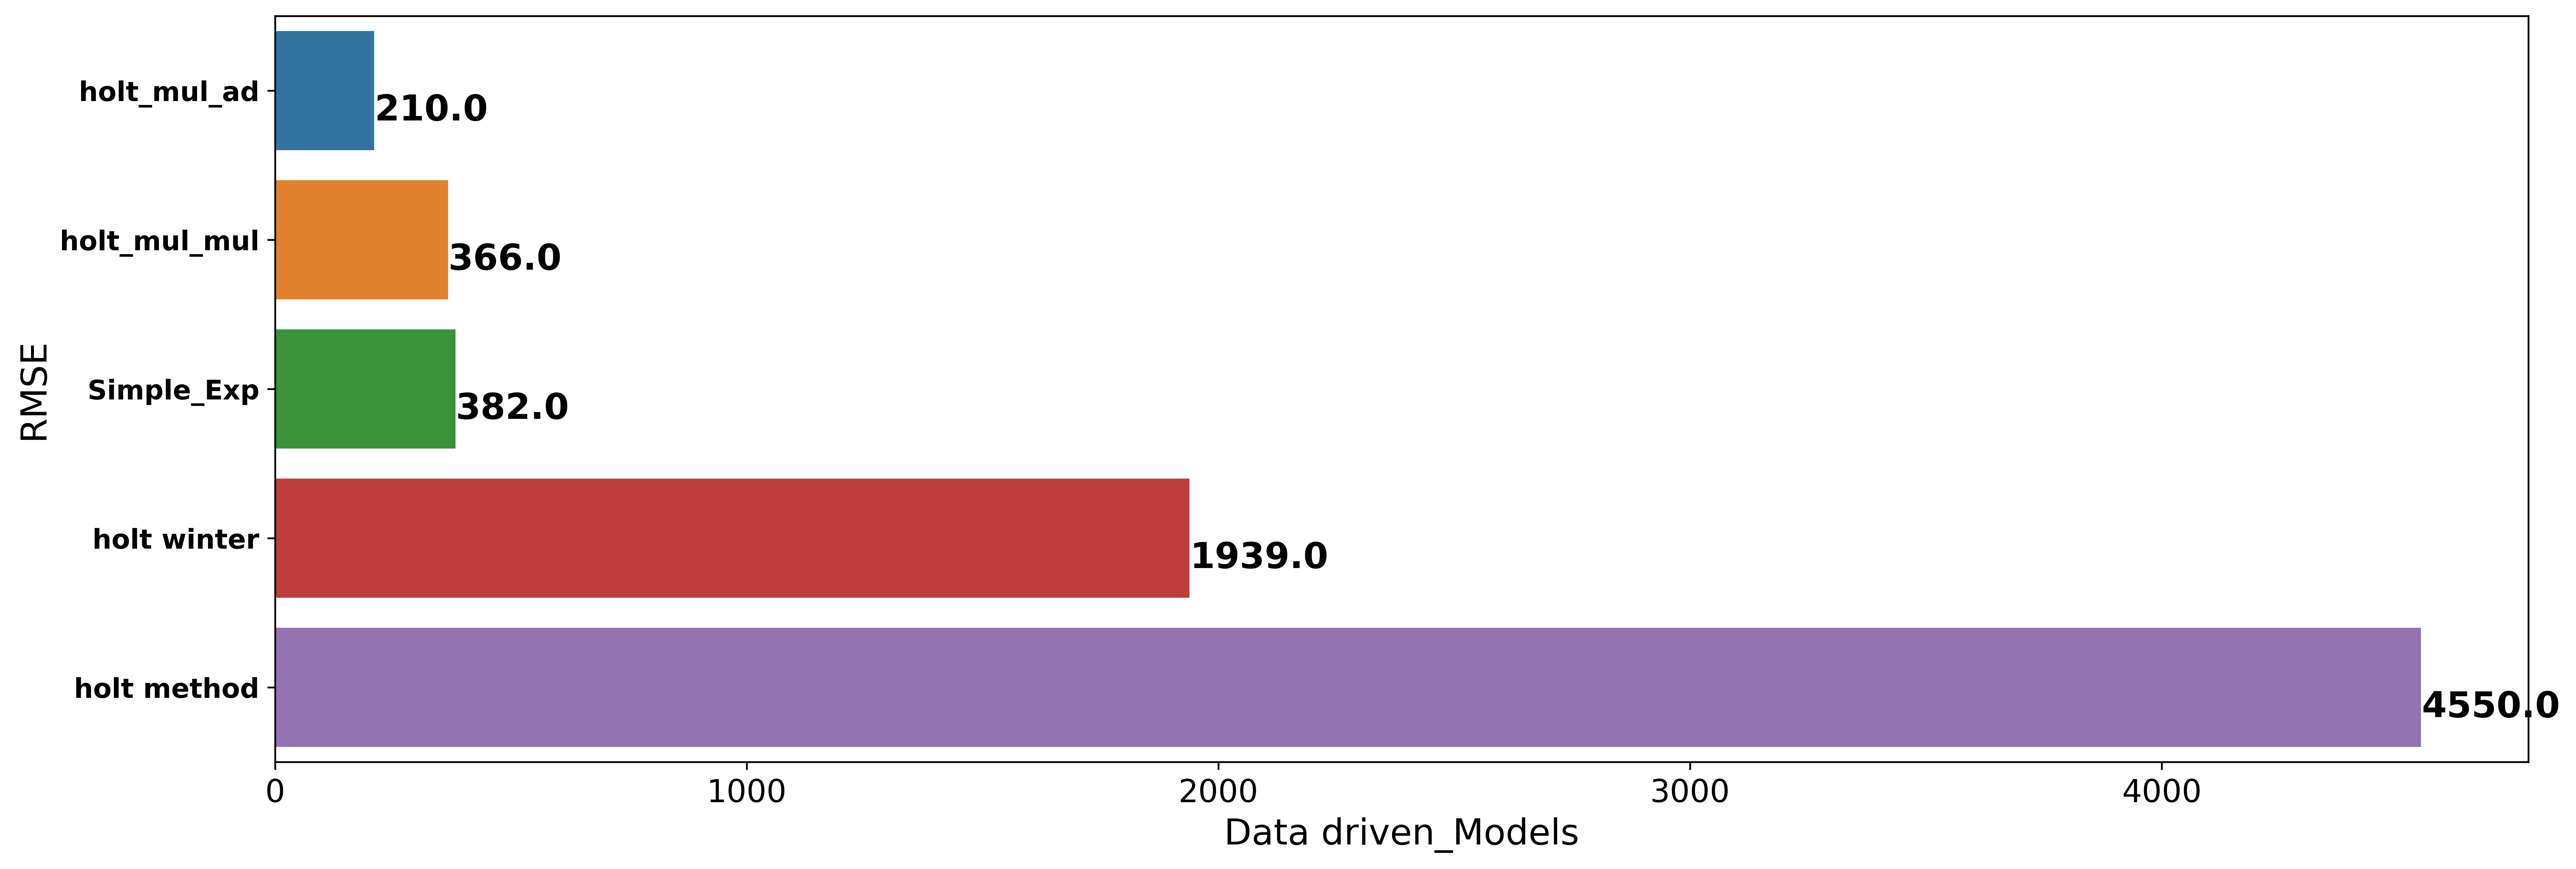

In [831]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sn.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Data driven_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)



We Observe that when we compared our data driven Models holts multiplicative seasonality and additive trend has performed better compared to other models 

## Autoregressive Integrated Moving Averages (ARIMA)

Test of stationarity

In [832]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

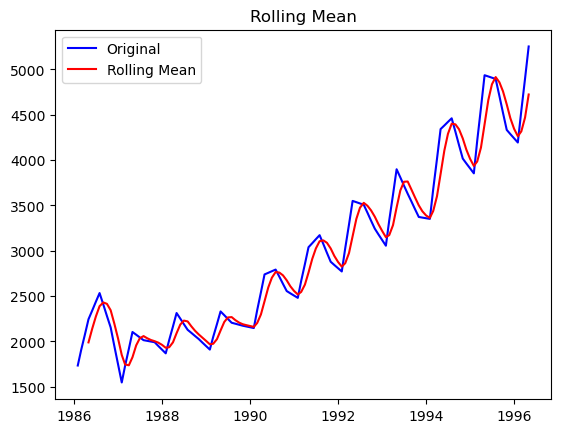

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [833]:
#plotting to check the rolling mean 
roll = pd.DataFrame()
roll['Sales'] = inter_month[['Sales']]
test_stationarity(roll)

In [834]:
#testing with adfuller with significant value
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [835]:
adf_test(roll.Sales)

Fail to reject the null hypothesis
Data is non-stationary


Since our data failed to accept the null hypothesis and our data is non-stationary as we know that for ARIMA model data has to be stationary we need to transform and also check with differencing 

## Feature Scaling

Square root Transformation

In [836]:
sqr_root = pd.DataFrame()
sqr_root = inter_month[['Sales']]
sqr_root['Sales'] = np.sqrt(sqr_root.Sales)

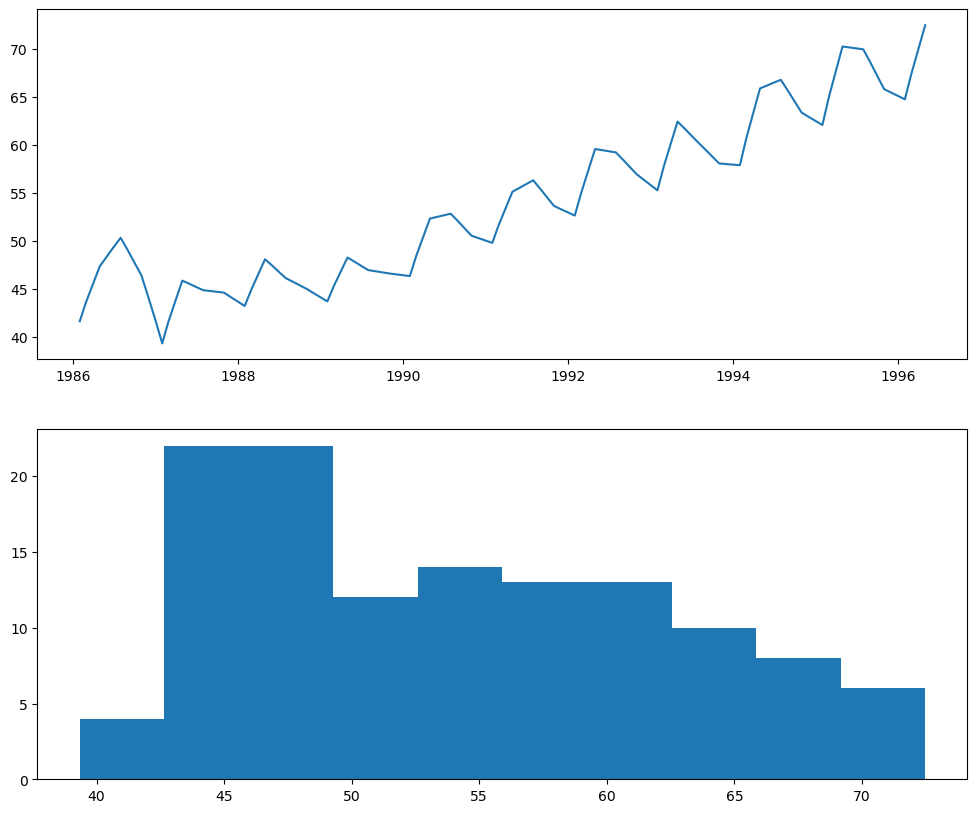

In [837]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(sqr_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(sqr_root['Sales'])
plt.show()


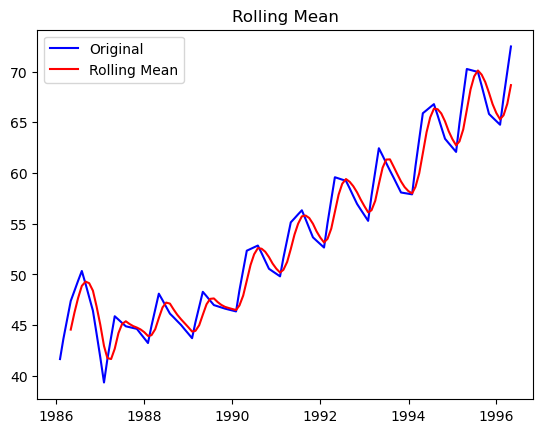

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [838]:
test_stationarity(sqr_root)

In [839]:
adf_test(sqr_root)

Fail to reject the null hypothesis
Data is non-stationary


Log Transformation

In [840]:
log = pd.DataFrame()
log = inter_month[['Sales']]
log['Sales'] = np.log(log.Sales)


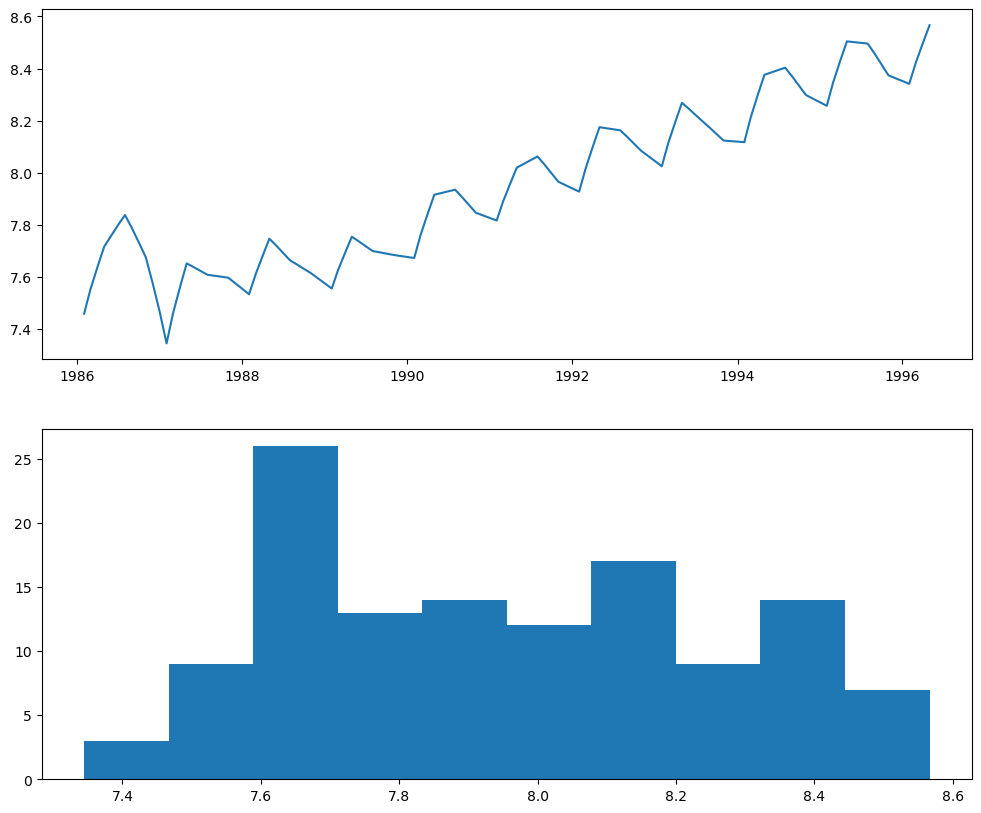

In [841]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()


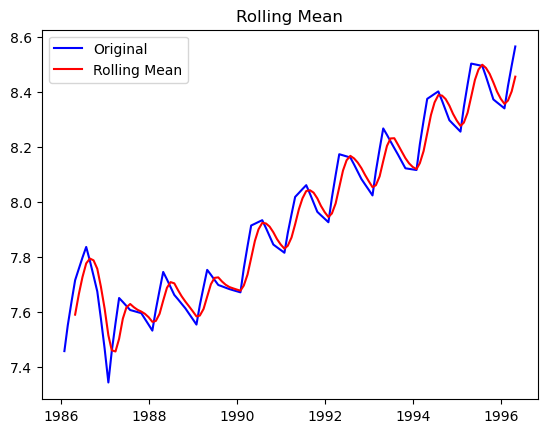

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [842]:
test_stationarity(log)

In [843]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


Converting Non-Stationary Time Series into Stationary

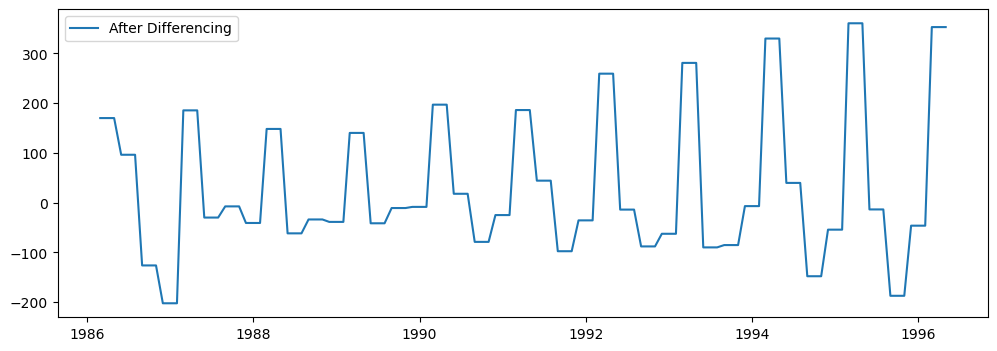

In [844]:
#applying differencing on our data 
diff = inter_month - inter_month.shift(1)
diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(diff, label='After Differencing')
plt.legend(loc='best')
plt.show()

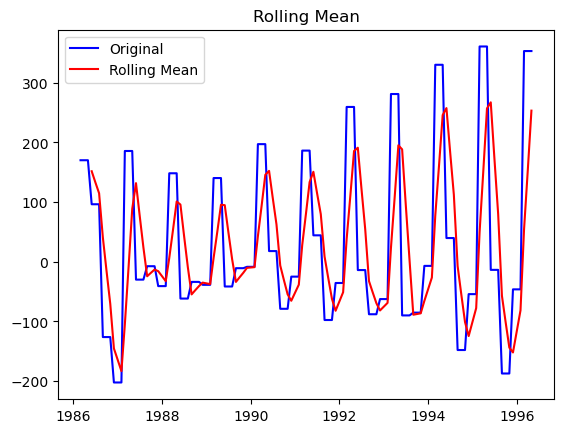

Results of Dickey Fuller Test:
Test Statistic                  -2.420372
p-value                          0.136069
#Lags Used                       9.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [845]:
test_stationarity(diff)

In [846]:
adf_test(diff)

Fail to reject the null hypothesis
Data is non-stationary


Seasonal Differencing

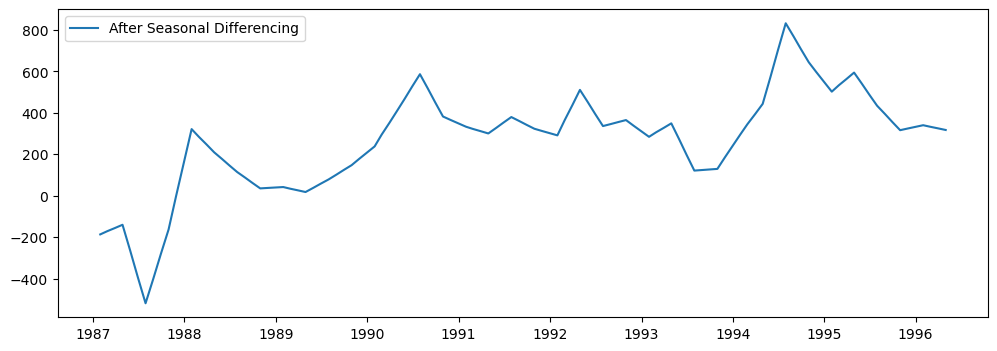

In [847]:
s_diff = inter_month - inter_month.shift(12)
s_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(s_diff, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

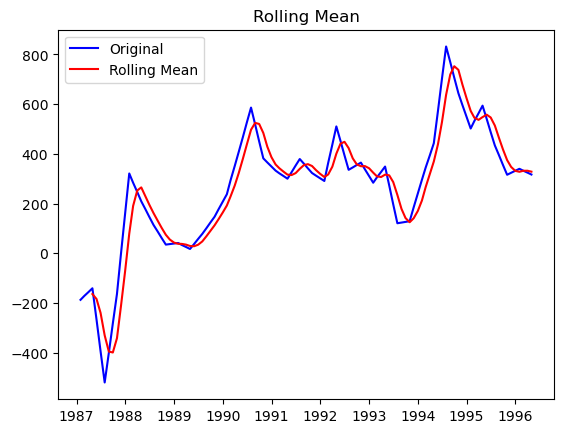

Results of Dickey Fuller Test:
Test Statistic                  -3.551949
p-value                          0.006749
#Lags Used                       4.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [848]:
test_stationarity(s_diff)

In [849]:
adf_test(s_diff)

Reject the null hypothesis
Data is stationary


Transformation Differencing

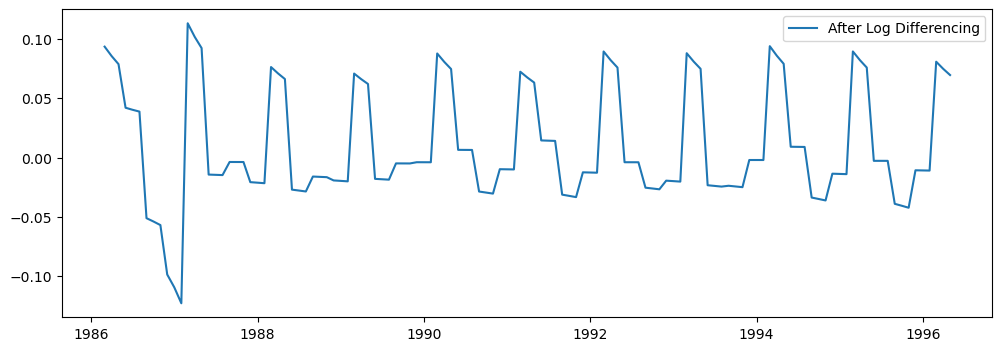

In [850]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

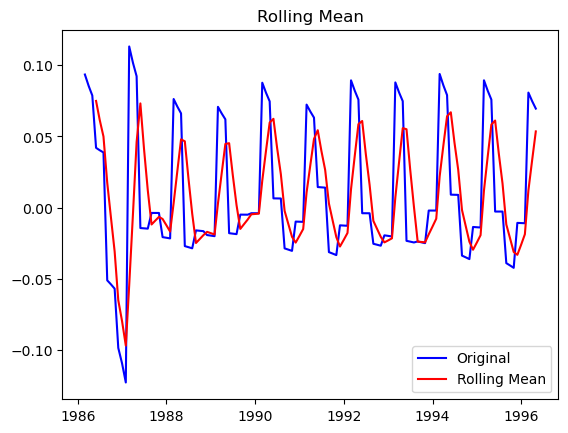

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [851]:
test_stationarity(log_diff)

In [852]:
adf_test(log_diff)

Reject the null hypothesis
Data is stationary


Box Cox Transformation

Sales
Date                
1986-01-31  7.458663
1986-02-28  7.552170
1986-03-31  7.637676
1986-04-30  7.716443
1986-05-31  7.758437

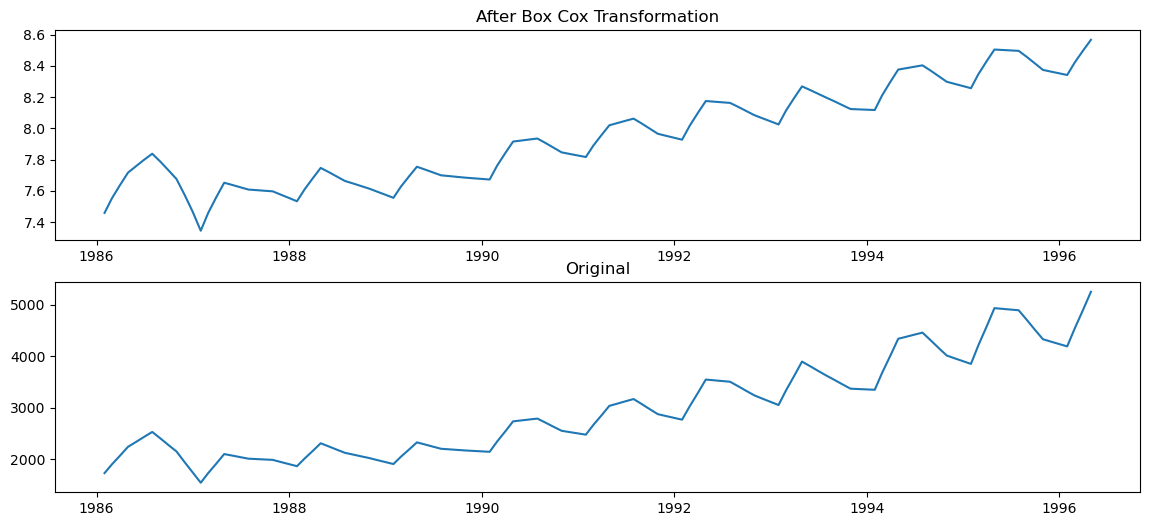

In [853]:
df_boxcox = pd.DataFrame()
df_boxcox['Sales'] = pd.Series(boxcox(inter_month['Sales'], lmbda=0), inter_month.index)
display(df_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(df_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(inter_month, label='original')
axis[1].set_title('Original')
plt.show()

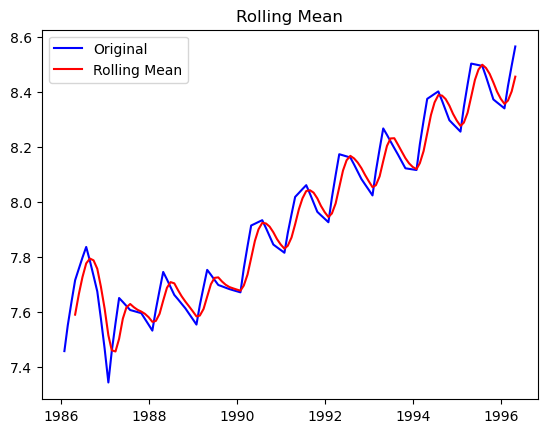

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [854]:
test_stationarity(df_boxcox)

We observe that the variance in earlier and later years is constant,but since the graph has an upward trend it indicates that our mean is not yet constant , therefore we have to go ahead with differencing

In [855]:
adf_test(df_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


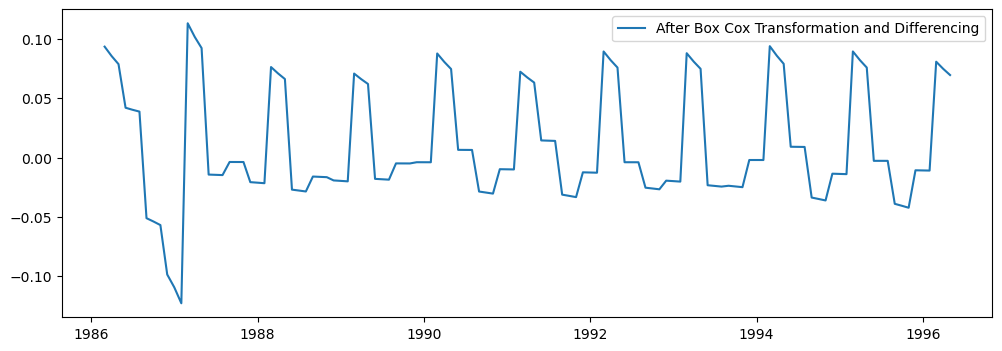

In [856]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
df_boxcox_diff = df_boxcox - df_boxcox.shift()
df_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

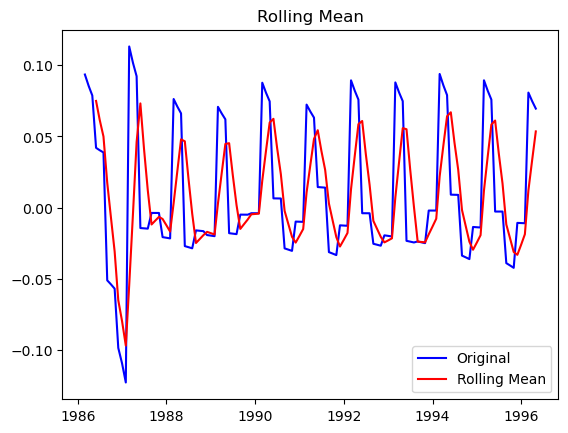

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [857]:
#check this boxcox transfered data with function
test_stationarity(df_boxcox_diff)

In [858]:
adf_test(df_boxcox_diff)

Reject the null hypothesis
Data is stationary


Now we have got our data stationary both for log diffrencing and boxcox and the value is lower than the significant value as estimated for adfuller test, we can go with any one of them for arima  

## Hyperparameter tuning for ARIMA

In [859]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [860]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_model(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [910]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_model(df_boxcox_diff.Sales, p_values, d_values, q_values)

Best ARIMA(4, 0, 4) RMSE=0.025


In [861]:
#building timeseries model with optimal parameters 
train_boxcox = df_boxcox[:100]
test_boxcox = df_boxcox[100:]
train_boxcox_diff = df_boxcox_diff[:99]
test_boxcox_diff = df_boxcox_diff[99:]

Inverse transformation of the Box-Cox Differencing

In [862]:
model = ARIMA(train_boxcox_diff,order=(4,0,4))
model_fit = model.fit()
y_hat_ar = df_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(df_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

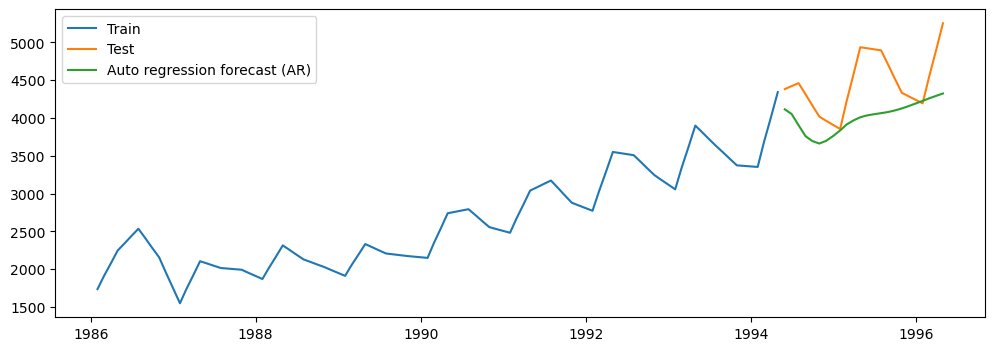

In [863]:
#plotting our arima model
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [864]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

530.42

In [865]:
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

9.64

Our AR model has moderately done a good job but compared the other models the performance is lower 

Analysing the residuals 

In [866]:
## residuals must be closer to zero or zero ##

In [867]:
model_residual = model_fit.resid
model_residual.mean()

0.0004722774301532468

In [868]:
##residuals must be stationary ##

In [869]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


In [870]:
## no autocorrelaton between the residuals ##

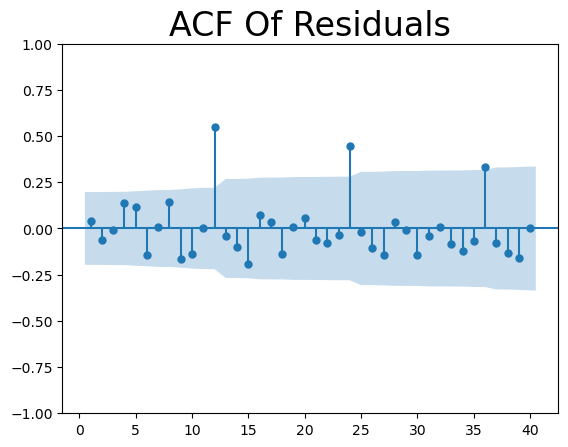

In [871]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals",size=24)
plt.show()

In [872]:
## residuals must be random ##

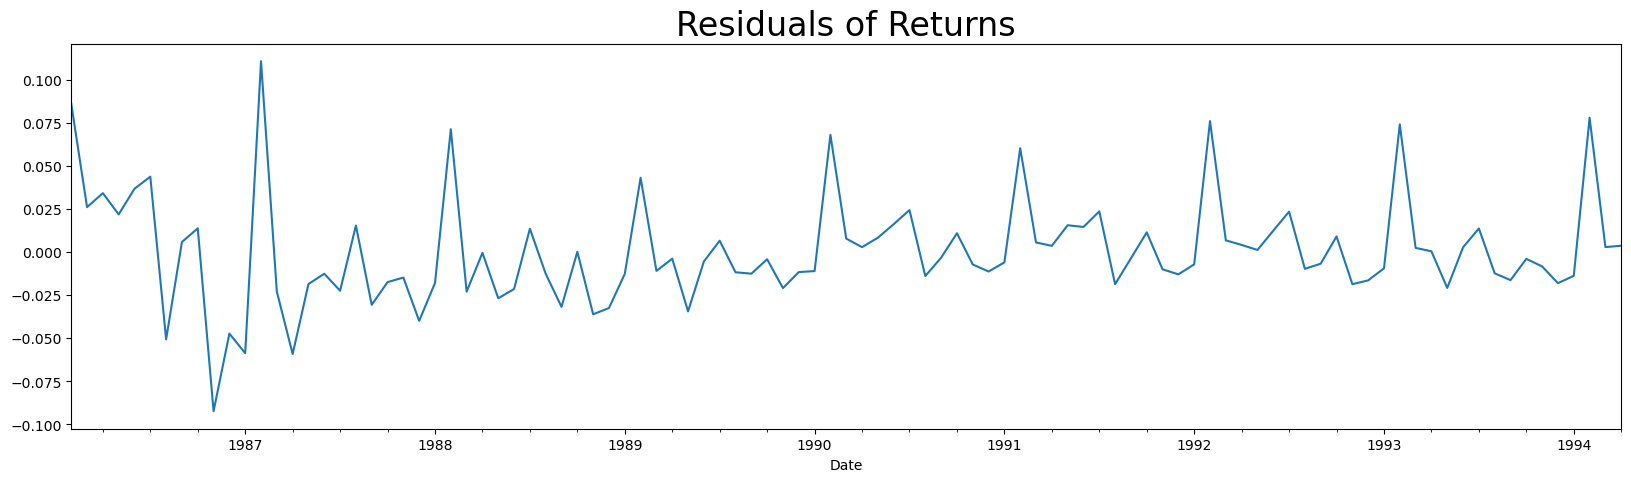

In [873]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

## Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [874]:
#fitting sarimax model
model = SARIMAX(train_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = df_boxcox_diff.copy()

In [875]:
#reversing the log boxcox transformation 
y_hat_sarima['sarima_forecast_boxcox']= model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast']=np.exp(y_hat_sarima['sarima_forecast_boxcox'])

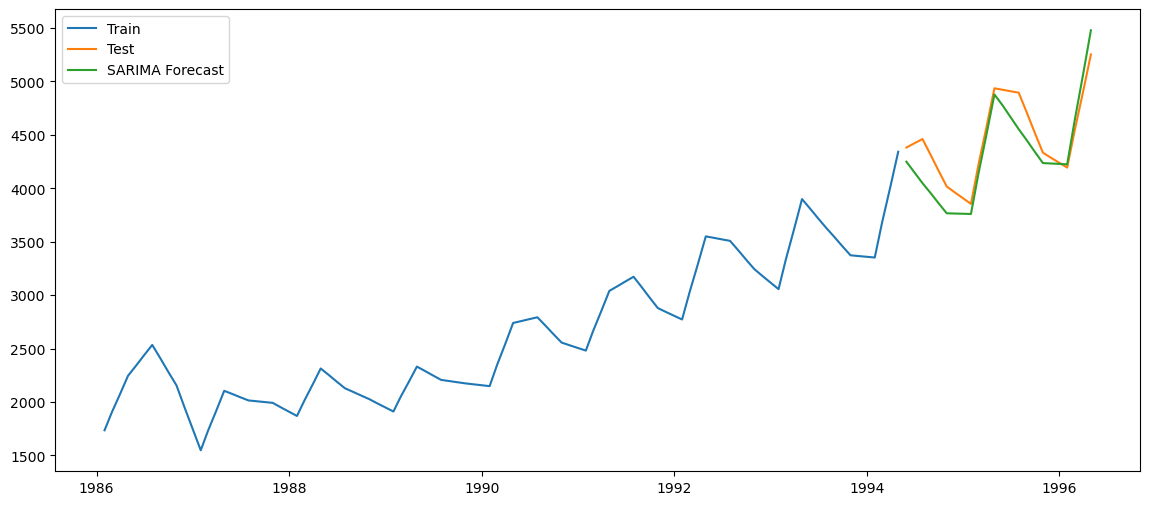

In [876]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In our Sarima plot we have successfully captured Trend and Seasonality

In [877]:
#root mean square error
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

206.61

In [878]:
#mean absolute error
mape_sarima = round(np.mean(np.abs((test_data.Sales - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_sarima

3.94

The performance is good comparative to other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality.

Analysing the Residuals

In [879]:
## residuals must be closer to zero or zero ##

In [880]:
model_residual = model_fit.resid
model_residual.mean()

0.03703966844162099

In [881]:
##residuals must be stationary ##

In [882]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


In [883]:
## no autocorrelaton between the residuals ##

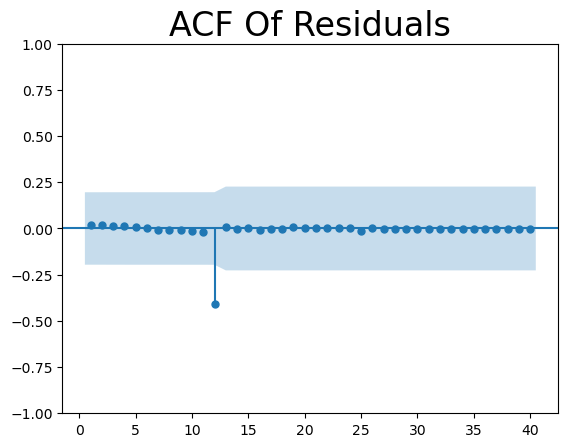

In [884]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals",size=24)
plt.show()

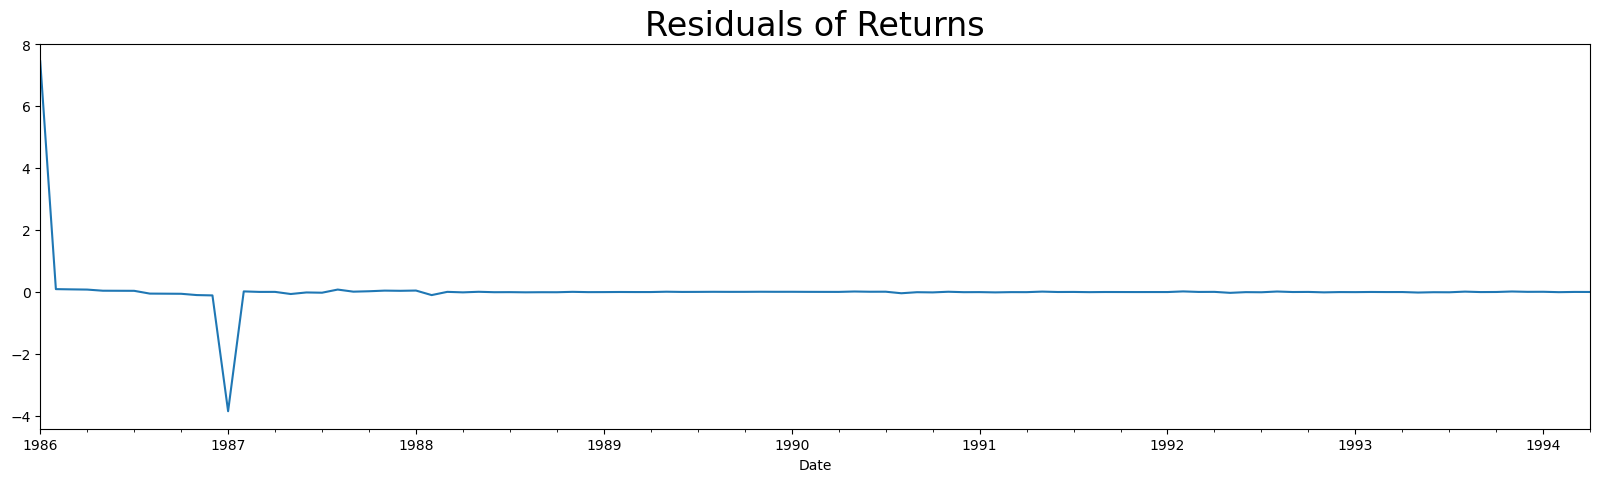

In [885]:
#residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [886]:
#validating results
Results = {"Models":pd.Series(["Simple_Exp","holt method","holt winter","holt_mul_ad","holt_mul_mul"\
                                ,"arima","Sarima"  ]),\
        
        "Test_MAPE(%)":pd.Series([mape_ses,mape_hm,mape_hw,mape_hw_mul,mape_hw_mul_mul,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_hm,test_rmse_hw,test_rmse_hw_mul,test_rmse_hw_mul_mul,rmse_ARIMA,
                                      rmse_sarima])}
table_evaluation=pd.DataFrame(Results)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models  Test_MAPE(%)  RMSE_Values
0        Sarima      3.940000   206.610000
1   holt_mul_ad      3.636542   210.001406
2  holt_mul_mul      6.308444   366.464335
3    Simple_Exp      6.620374   382.447742
4         arima      9.640000   530.420000
5   holt winter     37.824069  1938.637795
6   holt method     89.494625  4549.907951

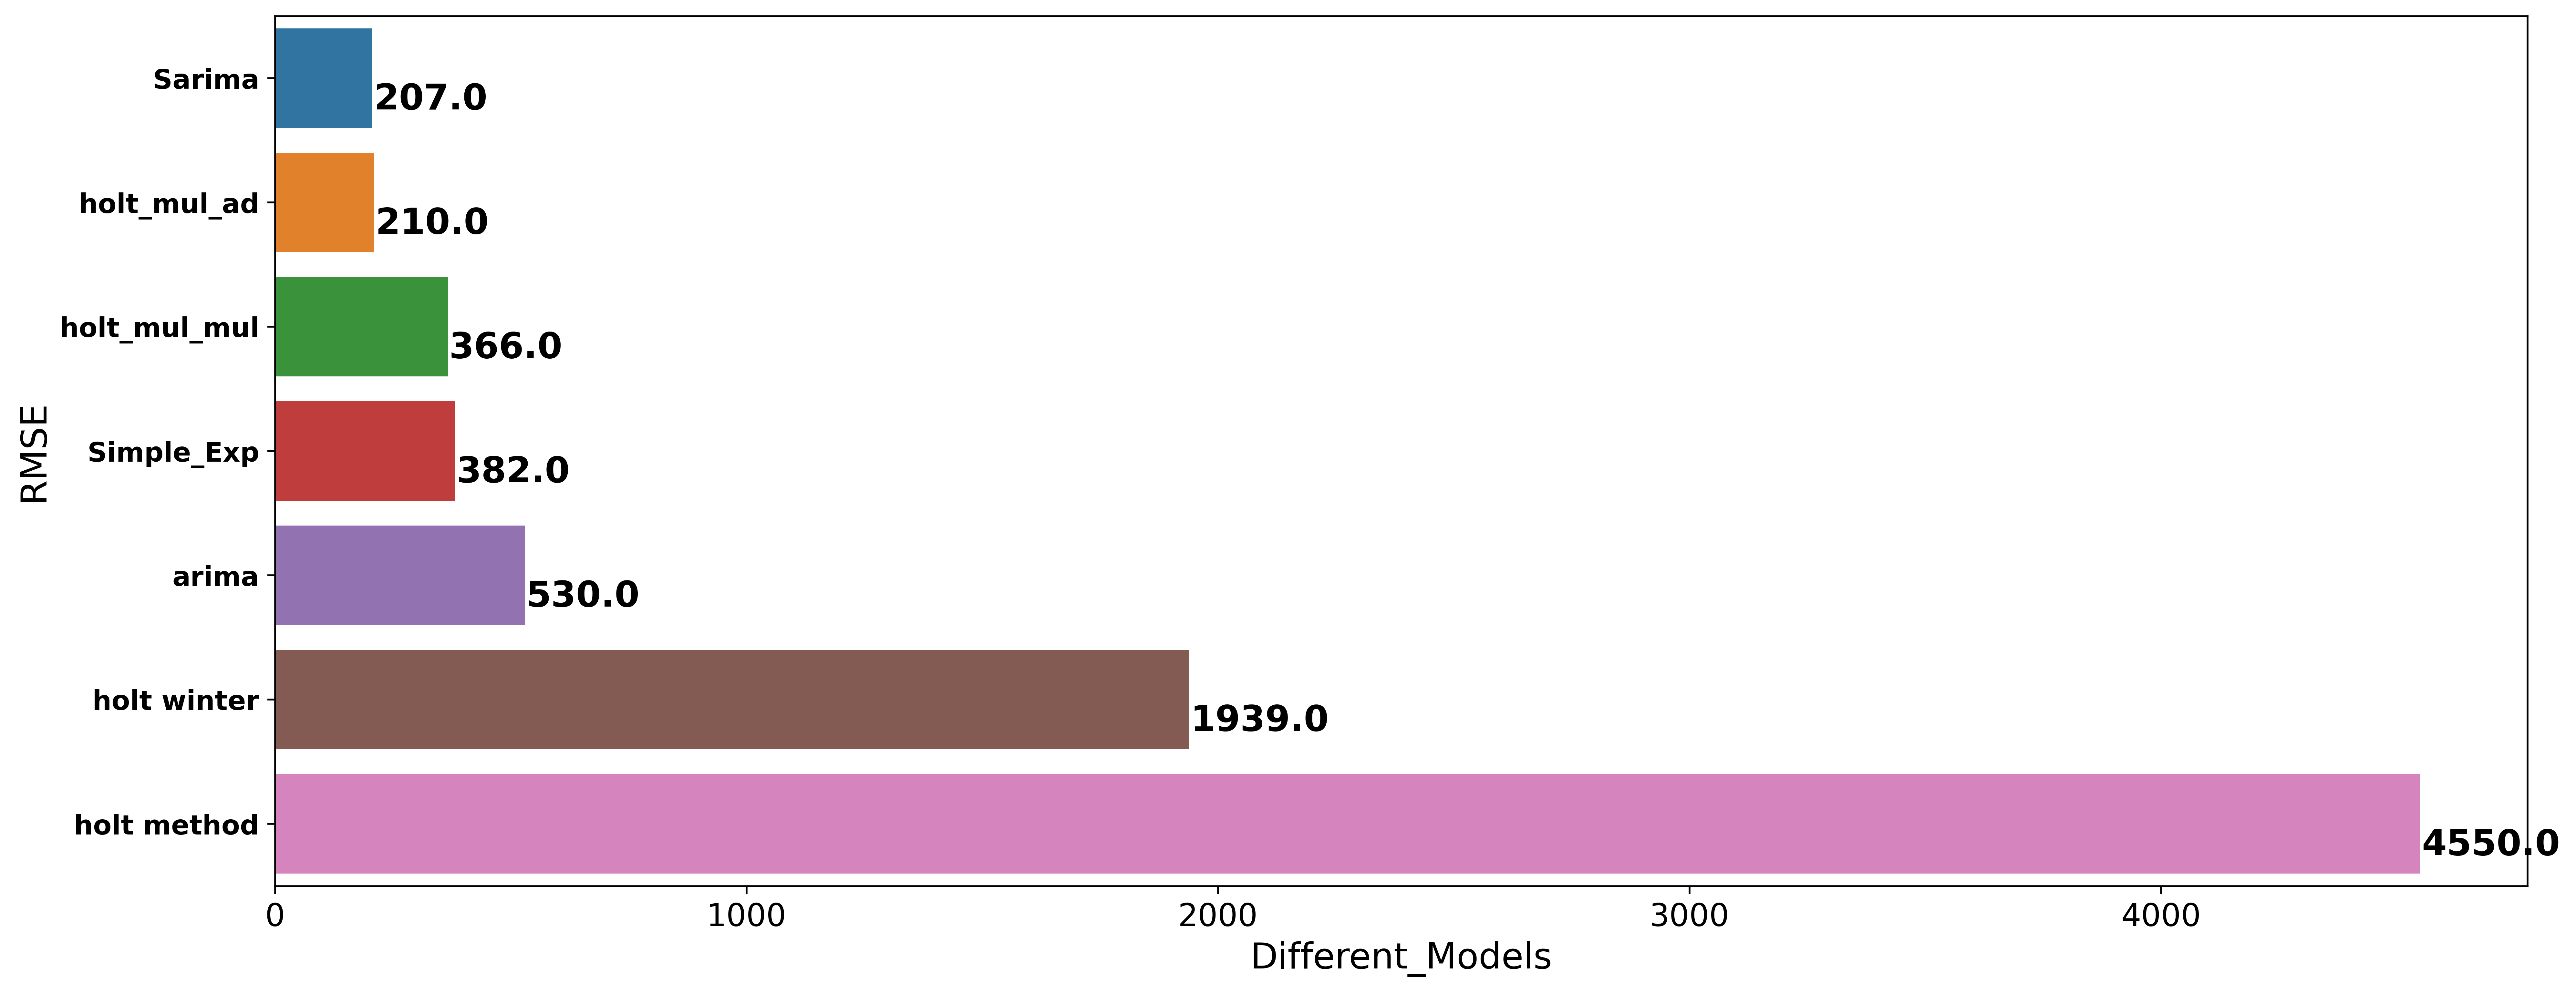

In [887]:
#plotting for all the model prepared 
f, axe = plt.subplots(1,1, figsize=(18,7), dpi=500)
sn.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

We fixed Multiple models to analyse trends and seasonality and with some models we captured both and seperately respectively, after all observation we find that sarima model performed better ,we could better results by hyperparameter tuning for sarima, but out of all this the holts multiplicative seasonality and additive trend  gave the best results than other models 

## Model driven Methods 

Data Preprocessing

In [888]:
inter_month.reset_index(inplace=True)
inter_month['t'] = np.arange(1,len(inter_month)+1)
inter_month['t_squared'] = np.square(inter_month.t)
inter_month["month"] = inter_month.Date.dt.strftime("%b") # month extraction
inter_month["year"] = inter_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(inter_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([inter_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
0   1986-01-31  1734.827000    1          1   Jan  1986    1    0    0    0   
1   1986-02-28  1904.871666    2          4   Feb  1986    0    1    0    0   
2   1986-03-31  2074.916332    3          9   Mar  1986    0    0    1    0   
3   1986-04-30  2244.960999    4         16   Apr  1986    0    0    0    1   
4   1986-05-31  2341.242330    5         25   May  1986    0    0    0    0   
..         ...          ...  ...        ...   ...   ...  ...  ...  ...  ...   
119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0    0   
120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0    0   
121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0    0   
122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1    0   
123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0    1   

     May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0      0    0    0    0    0    0    0    0   7.458663  
1      0    0    0    0    0    0    0    0   7.552170  
2      0    0    0    0    0    0    0    0   7.637676  
3      0    0    0    0    0    0    0    0   7.716443  
4      1    0    0    0    0    0    0    0   7.758437  
..   ...  ...  ...  ...  ...  ...  ...  ...        ...  
119    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0   8.496990  
123    0    0    0    0    0    0    0    0   8.566555  

[124 rows x 19 columns]

<AxesSubplot:xlabel='month', ylabel='year'>

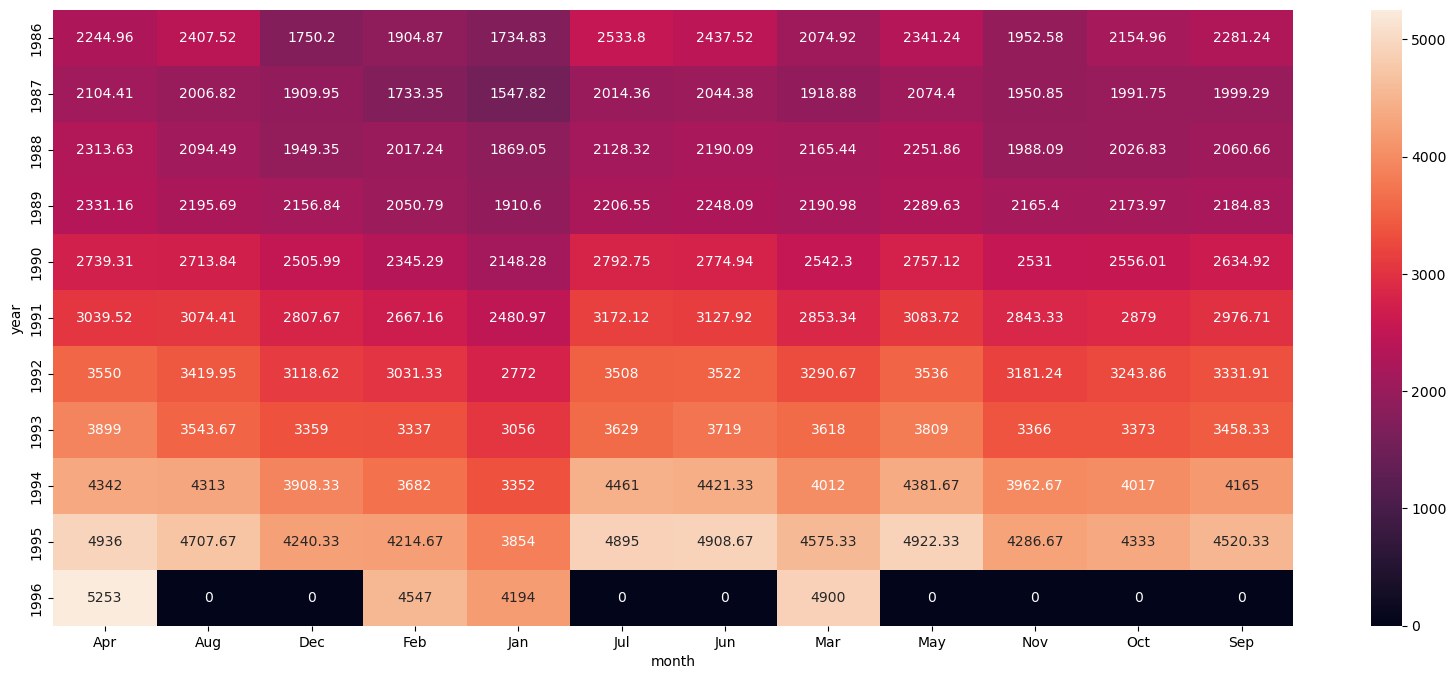

In [889]:

plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sn.heatmap(heatmap_y_month,annot=True,fmt="g")

In [890]:
#splitting into train and test method 
size = 100
train_df = cocacola.iloc[:size]
test_df = cocacola.iloc[size:]

In [891]:
train_df

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
0  1986-01-31  1734.827000    1          1   Jan  1986    1    0    0    0   
1  1986-02-28  1904.871666    2          4   Feb  1986    0    1    0    0   
2  1986-03-31  2074.916332    3          9   Mar  1986    0    0    1    0   
3  1986-04-30  2244.960999    4         16   Apr  1986    0    0    0    1   
4  1986-05-31  2341.242330    5         25   May  1986    0    0    0    0   
..        ...          ...  ...        ...   ...   ...  ...  ...  ...  ...   
95 1993-12-31  3359.000000   96       9216   Dec  1993    0    0    0    0   
96 1994-01-31  3352.000000   97       9409   Jan  1994    1    0    0    0   
97 1994-02-28  3682.000000   98       9604   Feb  1994    0    1    0    0   
98 1994-03-31  4012.000000   99       9801   Mar  1994    0    0    1    0   
99 1994-04-30  4342.000000  100      10000   Apr  1994    0    0    0    1   

    May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0     0    0    0    0    0    0    0    0   7.458663  
1     0    0    0    0    0    0    0    0   7.552170  
2     0    0    0    0    0    0    0    0   7.637676  
3     0    0    0    0    0    0    0    0   7.716443  
4     1    0    0    0    0    0    0    0   7.758437  
..  ...  ...  ...  ...  ...  ...  ...  ...        ...  
95    0    0    0    0    0    0    0    1   8.119399  
96    0    0    0    0    0    0    0    0   8.117312  
97    0    0    0    0    0    0    0    0   8.211211  
98    0    0    0    0    0    0    0    0   8.297045  
99    0    0    0    0    0    0    0    0   8.376090  

[100 rows x 19 columns]

In [892]:
test_df

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
100 1994-05-31  4381.666667  101      10201   May  1994    0    0    0    0   
101 1994-06-30  4421.333333  102      10404   Jun  1994    0    0    0    0   
102 1994-07-31  4461.000000  103      10609   Jul  1994    0    0    0    0   
103 1994-08-31  4313.000000  104      10816   Aug  1994    0    0    0    0   
104 1994-09-30  4165.000000  105      11025   Sep  1994    0    0    0    0   
105 1994-10-31  4017.000000  106      11236   Oct  1994    0    0    0    0   
106 1994-11-30  3962.666667  107      11449   Nov  1994    0    0    0    0   
107 1994-12-31  3908.333333  108      11664   Dec  1994    0    0    0    0   
108 1995-01-31  3854.000000  109      11881   Jan  1995    1    0    0    0   
109 1995-02-28  4214.666667  110      12100   Feb  1995    0    1    0    0   
110 1995-03-31  4575.333333  111      12321   Mar  1995    0    0    1    0   
111 1995-04-30  4936.000000  112      12544   Apr  1995    0    0    0    1   
112 1995-05-31  4922.333333  113      12769   May  1995    0    0    0    0   
113 1995-06-30  4908.666667  114      12996   Jun  1995    0    0    0    0   
114 1995-07-31  4895.000000  115      13225   Jul  1995    0    0    0    0   
115 1995-08-31  4707.666667  116      13456   Aug  1995    0    0    0    0   
116 1995-09-30  4520.333333  117      13689   Sep  1995    0    0    0    0   
117 1995-10-31  4333.000000  118      13924   Oct  1995    0    0    0    0   
118 1995-11-30  4286.666667  119      14161   Nov  1995    0    0    0    0   
119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0    0   
120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0    0   
121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0    0   
122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1    0   
123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0    1   

     May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
100    1    0    0    0    0    0    0    0   8.385184  
101    0    1    0    0    0    0    0    0   8.394197  
102    0    0    1    0    0    0    0    0   8.403128  
103    0    0    0    1    0    0    0    0   8.369389  
104    0    0    0    0    1    0    0    0   8.334472  
105    0    0    0    0    0    1    0    0   8.298291  
106    0    0    0    0    0    0    1    0   8.284672  
107    0    0    0    0    0    0    0    1   8.270866  
108    0    0    0    0    0    0    0    0   8.256867  
109    0    0    0    0    0    0    0    0   8.346326  
110    0    0    0    0    0    0    0    0   8.428435  
111    0    0    0    0    0    0    0    0   8.504311  
112    1    0    0    0    0    0    0    0   8.501538  
113    0    1    0    0    0    0    0    0   8.498758  
114    0    0    1    0    0    0    0    0   8.495970  
115    0    0    0    1    0    0    0    0   8.456948  
116    0    0    0    0    1    0    0    0   8.416341  
117    0    0    0    0    0    1    0    0   8.374015  
118    0    0    0    0    0    0    1    0   8.363265  
119    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0   8.496990  
123    0    0    0    0    0    0    0    0   8.566555

Linear Model By Ordinary Least Square

In [893]:
linear_model = smf.ols('Sales~t',data=train_df).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(test_df['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668943

In [894]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     397.1
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           3.03e-36
Time:                        15:28:38   Log-Likelihood:                -705.92
No. Observations:                 100   AIC:                             1416.
Df Residuals:                      98   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1642.3384     57.309     28.658      0.000    1528.611    1756.065
t             19.6334      0.985     19.928      0.000      17.678      21.589
==============================================================================
Omnibus:                        7.535   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.789
Skew:                           0.683   Prob(JB):                       0.0204
Kurtosis:                       2.929   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [895]:
exp_model = smf.ols('log_sales~t',data=train_df).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test_df['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

530.3268025099009

Exponential

In [896]:
exp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.20e-36
Time:                        15:28:39   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quadratic

In [897]:
quad_model = smf.ols('Sales~t+t_squared',data=train_df).fit()
pred_quad = pd.Series(quad_model.predict(pd.DataFrame(test_df[["t","t_squared"]])))
rmse_quad = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(pred_quad))**2))
rmse_quad

371.29418344986647

Additive Seasonality

In [898]:
add_model = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_df).fit()
pred_add = pd.Series(add_model.predict(test_df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec']]))
rmse_add = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(pred_add))**2))
rmse_add

1837.7879723483788

In [899]:
add_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Mon, 27 Feb 2023   Prob (F-statistic):              0.806
Time:                        15:28:39   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan         -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb           98.7249    208.114      0.474      0.636    -314.858     512.308
Mar          309.5564    208.114      1.487      0.140    -104.026     723.139
Apr          520.3878    208.114      2.500      0.014     106.805     933.971
May          336.7034    219.714      1.532      0.129     -99.932     773.339
Jun          326.8245    219.714      1.488      0.140    -109.811     763.460
Jul          316.9457    219.714      1.443      0.153    -119.690     753.581
Aug          250.8819    219.714      1.142      0.257    -185.753     687.517
Sep          184.8182    219.714      0.841      0.403    -251.817     621.453
Oct          118.7544    219.714      0.540      0.590    -317.881     555.390
Nov           66.1439    219.714      0.301      0.764    -370.491     502.779
Dec           13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     1.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.42e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Additive Seasonality Quadratic

In [900]:
add_model_seq = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_df).fit()
pred_add_seq = pd.Series(add_model_seq.predict(test_df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec','t','t_squared']]))
rmse_add_seq = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(pred_add_seq))**2))
rmse_add_seq

225.80498810372768

In [901]:
add_model_seq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           8.95e-52
Time:                        15:28:39   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1865.7939     41.512     44.946      0.000    1783.271    1948.316
t             -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared      0.2253      0.020     11.418      0.000       0.186       0.265
Jan         -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb           31.7000     46.733      0.678      0.499     -61.202     124.602
Mar          222.7184     46.754      4.764      0.000     129.774     315.663
Apr          413.2862     46.781      8.834      0.000     320.288     506.284
May          372.3785     49.451      7.530      0.000     274.074     470.683
Jun          344.0384     49.465      6.955      0.000     245.706     442.371
Jul          315.2478     49.481      6.371      0.000     216.884     413.612
Aug          229.8216     49.499      4.643      0.000     131.421     328.222
Sep          143.9448     49.519      2.907      0.005      45.505     242.385
Oct           57.6174     49.541      1.163      0.248     -40.867     156.102
Nov          -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec          -89.4829     49.592     -1.804      0.075    -188.068       9.102
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     6.72e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Multiplicative Seasonality

In [902]:
mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_df).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_df))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1904.7944171920326

In [903]:
mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Mon, 27 Feb 2023   Prob (F-statistic):              0.767
Time:                        15:28:39   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2447      0.022    324.766      0.000       7.200       7.289
Jan            0.4719      0.077      6.107      0.000       0.318       0.626
Feb            0.5592      0.077      7.236      0.000       0.406       0.713
Mar            0.6393      0.077      8.273      0.000       0.486       0.793
Apr            0.7134      0.077      9.232      0.000       0.560       0.867
May            0.6582      0.082      8.068      0.000       0.496       0.820
Jun            0.6547      0.082      8.025      0.000       0.493       0.817
Jul            0.6508      0.082      7.977      0.000       0.489       0.813
Aug            0.6277      0.082      7.694      0.000       0.466       0.790
Sep            0.6038      0.082      7.401      0.000       0.442       0.766
Oct            0.5791      0.082      7.098      0.000       0.417       0.741
Nov            0.5558      0.082      6.812      0.000       0.394       0.718
Dec            0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     1.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.42e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Multiplicative Additive Seasonality 

In [904]:
Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_df).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_df))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_df['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

396.41978173827204

In [905]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           4.29e-37
Time:                        15:28:39   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9000      0.015    450.015      0.000       6.870       6.931
t              0.0074      0.000     25.888      0.000       0.007       0.008
Jan            0.4543      0.026     17.240      0.000       0.402       0.507
Feb            0.5342      0.026     20.263      0.000       0.482       0.587
Mar            0.6069      0.026     23.011      0.000       0.554       0.659
Apr            0.6736      0.026     25.526      0.000       0.621       0.726
May            0.6553      0.028     23.563      0.000       0.600       0.711
Jun            0.6445      0.028     23.171      0.000       0.589       0.700
Jul            0.6332      0.028     22.759      0.000       0.578       0.688
Aug            0.6027      0.028     21.656      0.000       0.547       0.658
Sep            0.5714      0.028     20.523      0.000       0.516       0.627
Oct            0.5392      0.028     19.360      0.000       0.484       0.595
Nov            0.5085      0.028     18.246      0.000       0.453       0.564
Dec            0.4763      0.028     17.077      0.000       0.421       0.532
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     7.69e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.73e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [906]:
data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":
        pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add,rmse_add_seq,rmse_mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [907]:
e = table_rmse.append(table_evaluation)
e.drop('Test_MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

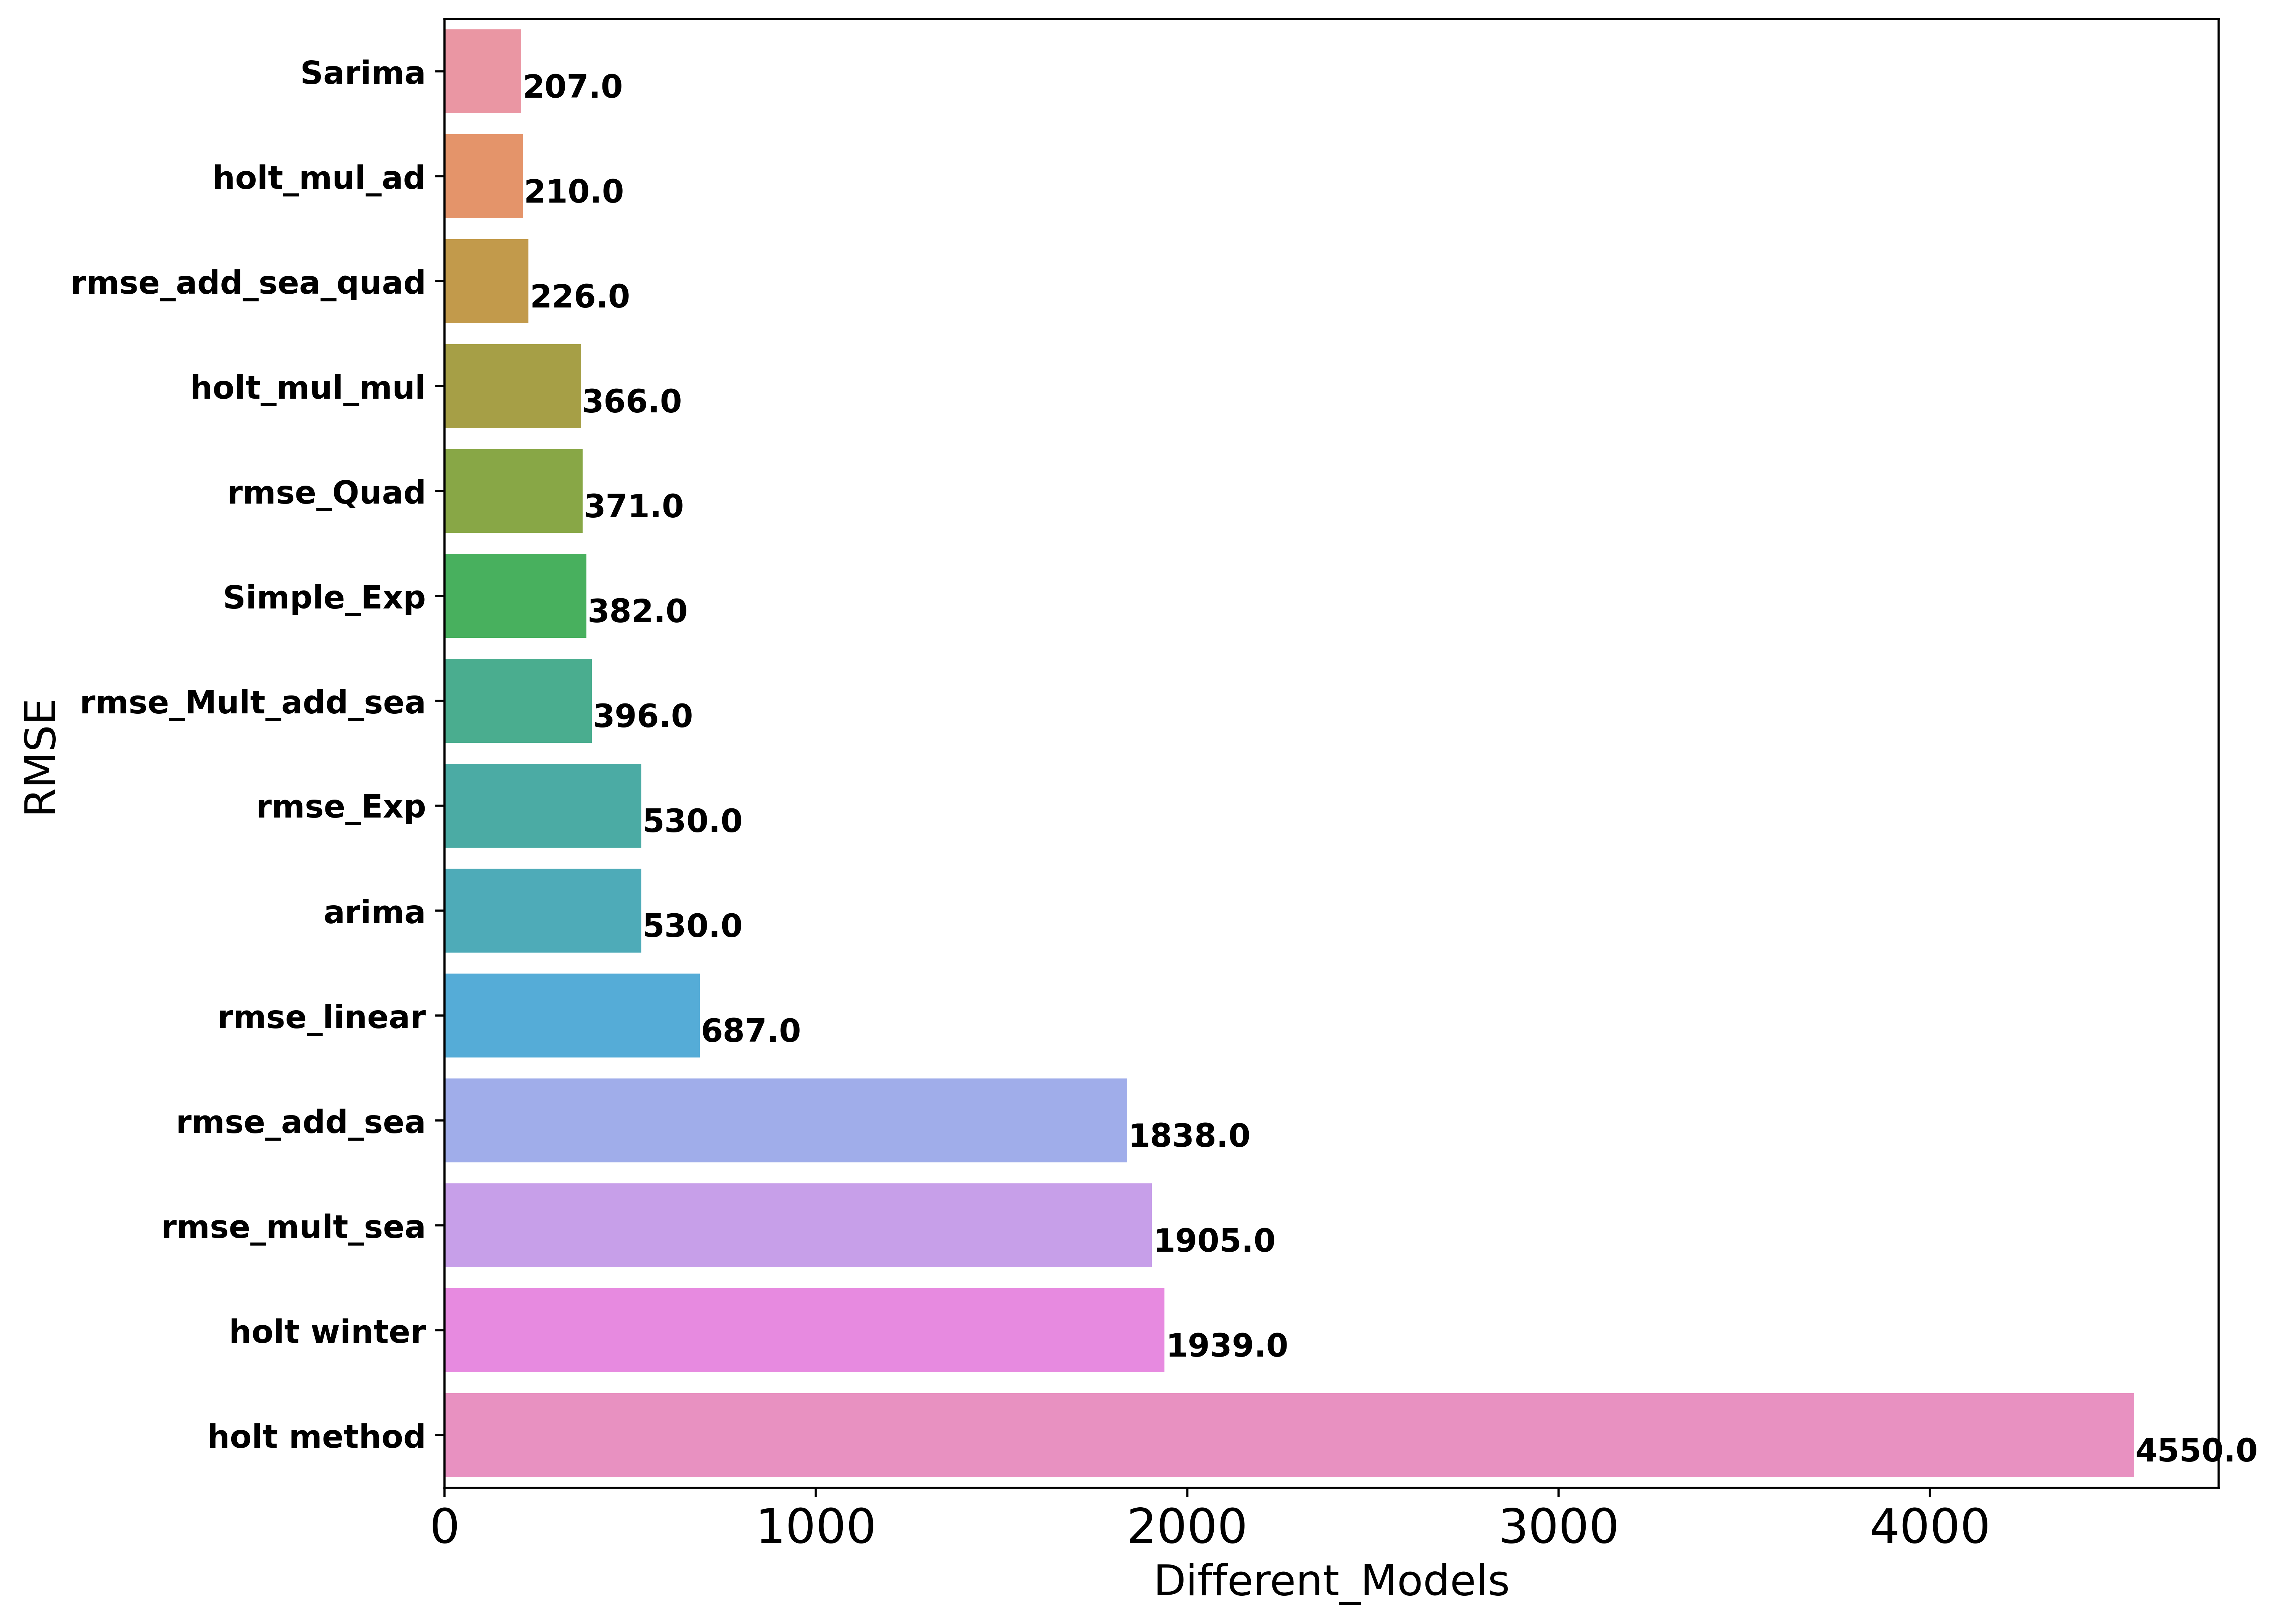

In [908]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sn.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()

Conclusion

1)We observed performance of all the models and we came to a conclusion that our sarima models has performed the best than all the models

2)we applied many methods like data driven methods and model based methods including ARIMA and SARIMAX and we observed that rmse had a great impact over predictions 

3))for ARIMA Model we converted our data from non stationary  to stationary and we also detected whether our data is stationary or not by applying adfuller test.

4)we have also used sarimax model but as we didnt tune the hyperparameters it merely gave us good results and better than Arima.
